In [1]:
from pymodulon.io import *
from pymodulon.plotting import *
from os import path
from pymodulon.compare import *

In [2]:
import matplotlib
import matplotlib.font_manager
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42

In [3]:
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib_venn import venn2

import plotly.express as px
import seaborn as sns

In [4]:
from scipy.stats import pearsonr

In [5]:
warnings.filterwarnings("ignore")

In [6]:
ica_data = load_json_model('../processed_data/ica_data.json.gz')

# Main Figures

## Figure 1

In [7]:
fig = px.treemap(ica_data.imodulon_table.sort_values('pilot_exp_var',ascending=False).drop(['Unchar_2','csp','Unchar_1']).reset_index().rename(columns={'index':'imod_name'}),
                path = ['category','imod_name'],
                values='pilot_exp_var',color='category')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.update_traces(marker=dict(cornerradius=5))
fig.update_traces(marker_line_width =0.5)
fig.update_layout(font=dict(family="Arial", size=12))
# fig.show(renderer='browser')
# fig.write_image('../Figures/treemap.pdf',scale=3)

## Figure 3

In [8]:
def time_series_heatmap(imod_list, plot_type='heatmap', cell_size=1.5, save=False, save_path=None, center=True):
    """
    Plot heatmaps for specified iModulon activities under different conditions.

    Parameters:
    -----------
    imod_list : list
        List of iModulons to include in the heatmap.
    cell_size : int, optional
        Size of each cell in the heatmap (default: 1).
    save : bool, optional
        If True, saves the plot to the specified path (default: False).
    save_path : str, optional
        File path to save the plot if `save` is True (default: None).
    center : bool, optional
        If True, center the heatmap color at 0 (default: True).

    Returns:
    --------
    None
    """

    def get_averages(columns,i):
        return [(A.loc[i, col1] + A.loc[i, col2]) / 2 for col1, col2 in columns]

    A = ica_data.A 

    # Define replicates for each condition
    cipro_replicates = [
        ('pilot_25', 'pilot_26'), ('pilot_27', 'pilot_28'),
        ('pilot_31', 'pilot_32'), ('pilot_35', 'pilot_36'),
        ('pilot_29', 'pilot_30'), ('pilot_33', 'pilot_34')
    ]
    amp4_replicates = [
        ('pilot_13', 'pilot_14'), ('pilot_15', 'pilot_16'),
        ('pilot_19', 'pilot_19'), ('pilot_23', 'pilot_24'),
        ('pilot_17', 'pilot_18'), ('pilot_21', 'pilot_22')
    ]
    amp16_replicates = [
        ('pilot_1', 'pilot_2'), ('pilot_3', 'pilot_4'),
        ('pilot_7', 'pilot_8'), ('pilot_11', 'pilot_12'),
        ('pilot_5', 'pilot_6'), ('pilot_9', 'pilot_10')
    ]
   
    
    def create_dataframe(replicates, name):
        data = [get_averages(replicates,i) for i in imod_list]
        return pd.DataFrame(data, index=imod_list, columns=['0+', '1.5 min', '3.5 min', '7.5 min', '15 min', '30 min'])

    cipro_df = create_dataframe(cipro_replicates, 'cipro')
    amp4_df = create_dataframe(amp4_replicates, 'amp4')
    amp16_df = create_dataframe(amp16_replicates, 'amp16')

    dataframes = {'cipro': cipro_df, 'amp4': amp4_df, 'amp16': amp16_df}

    # Generate heatmaps or line plots based on the user's choice
    if plot_type == 'heatmap':
        max_rows = len(imod_list)
        fig_width = 10 * cell_size
        fig_height = max_rows * cell_size

        # Create a figure with 3 heatmaps and adjust space between them
        fig, axes = plt.subplots(1, 3, figsize=(fig_width, fig_height),
                                 gridspec_kw={'width_ratios': [1, 1, 1], 'wspace': 0.5})

        # Helper function to plot heatmaps with consistent size
        def plot_heatmap(data, ax, show_cbar=False):
            sns.heatmap(
                data, ax=ax, cbar=show_cbar, square=True, cmap='coolwarm',
                center=0 if center else None, linewidths=0.7, linecolor='black'
            )
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right',fontsize=15)
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right',fontsize=15)

        # Plot each heatmap with consistent box sizes
        plot_heatmap(amp16_df, axes[0], show_cbar=False)
        plot_heatmap(amp4_df, axes[1], show_cbar=False)

        # Plot the last heatmap with a colorbar placed outside the grid
        cbar_ax = fig.add_axes([0.93, 0.3, 0.02, 0.4])  # Adjust colorbar position
        sns.heatmap(cipro_df, ax=axes[2], cbar=True, cbar_ax=cbar_ax, square=True,
                    cmap='coolwarm', center=0 if center else None, linewidths=0.7, linecolor='black')
        axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right',fontsize=15)
        axes[2].set_yticklabels(axes[2].get_yticklabels(), rotation=0, ha='right',fontsize=15)

        # Adjust layout to ensure consistent spacing
        plt.subplots_adjust(left=0.05, right=0.9, wspace=0.3)

    elif plot_type == 'line':
        # Calculate the number of rows and columns dynamically
        num_plots = len(imod_list)
        cols = 3  # Set the number of columns to 3
        rows = math.ceil(num_plots / cols)  # Calculate required number of rows

        # Create the figure with dynamic size
        fig = plt.figure(figsize=(24, rows * 6))  # Adjust figure size for readability
        gs = gridspec.GridSpec(rows, cols)  # Removed custom width/height ratios

        xticks = [0, 1.5, 3.5, 7, 15, 30]
        labels = ['0+', '1.5min', '3.5min', '7min', '15min', '30min']
        colors = {'cipro': 'chocolate', 'amp4': 'firebrick', 'amp16': 'blue'}

        # Helper function to plot a single modulon
        def plot_modulon(ax, modulon_name):
            data_missing = True  # Track if all data is missing
            for condition, df in dataframes.items():
                if modulon_name in df.index:
                    ax.plot(xticks, df.loc[modulon_name], '-o', label=condition, color=colors[condition])
                    data_missing = False
                else:
                    print(f"Warning: Missing data for iModulon '{modulon_name}' in {condition}")

            if data_missing:
                print(f"Warning: No data found for iModulon '{modulon_name}'.")

            # Customize ticks, labels, and grid
            ax.set_xticks(xticks)
            ax.set_xticklabels(labels, rotation=-45, ha='left', fontsize=14)
            ax.set_title(modulon_name, fontsize=20)  # Larger title font
            ax.grid(True)

        # Plot each iModulon dynamically
        for i, modulon_name in enumerate(imod_list):
            row, col = divmod(i, cols)  # Calculate correct position in the grid
            ax = fig.add_subplot(gs[row, col])  # Create subplot
            plot_modulon(ax, modulon_name)

            # Add y-axis label only for the first column of each row
            if col == 0:
                ax.set_ylabel('iModulon Activity', fontsize=16)  # Increased font size

        # Add a legend outside the plot area
        fig.legend(dataframes.keys(), loc='upper center', ncol=3, fontsize=16, bbox_to_anchor=(0.5, 1.05))

        # Use tight layout to remove excessive space
        plt.tight_layout()

        # Adjust layout to fit the legend neatly
        plt.subplots_adjust(top=0.9)

    # Save the plot if requested
    if save and save_path:
        fig.savefig(save_path, bbox_inches='tight', transparent=True)

    # Show the plot
    plt.show()


In [9]:
carbon = ['MalT','Crp-1','CdaR','GlcC','NanR','SrlR','GatR','XylR','AllR','FucR','GntR','PuuR','GlpR','prp/paa',
          'AscG','thi_gal','dsrA']
nucleotide = ['PurR-1','PurR-2']
respiration = ['ArcA-1','ArcA-2']

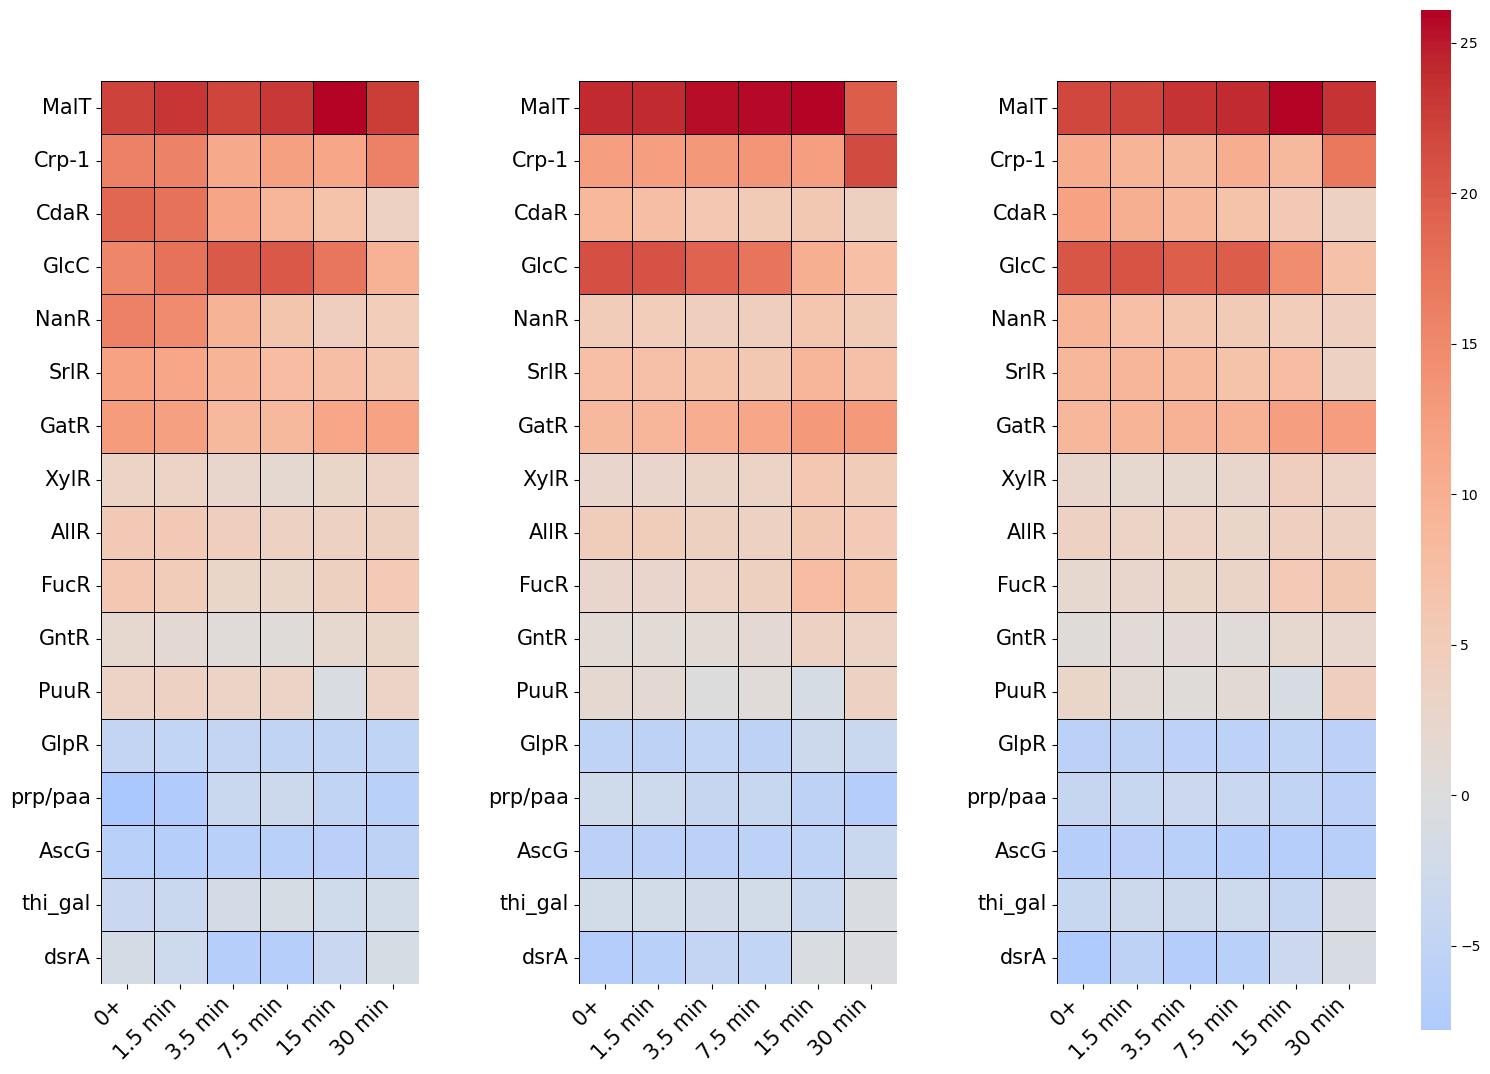

In [10]:
time_series_heatmap(carbon,plot_type='heatmap')

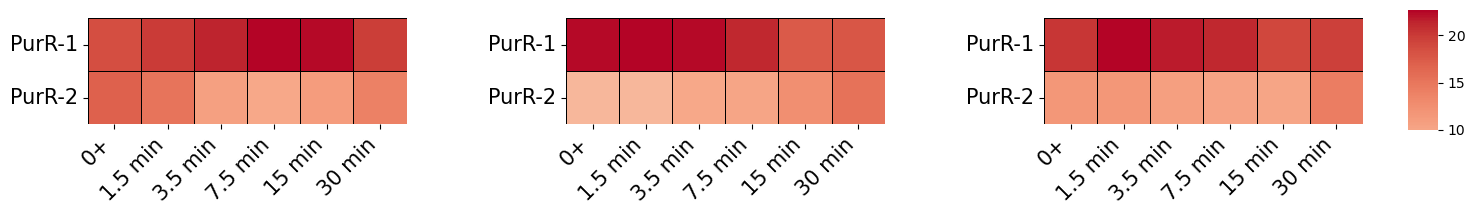

In [11]:
time_series_heatmap(nucleotide)

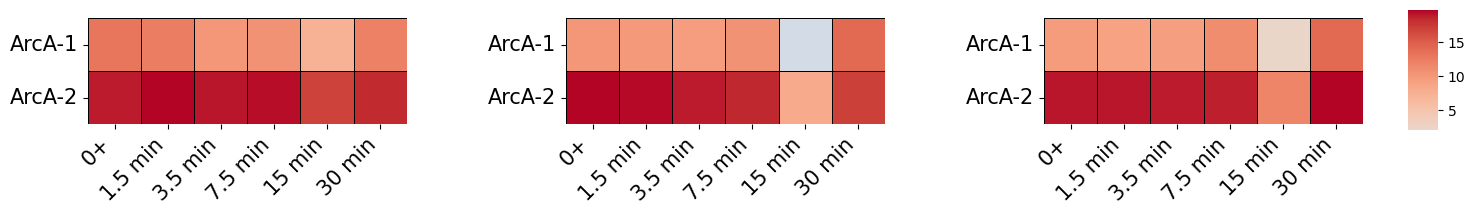

In [12]:
time_series_heatmap(respiration)

## Figure 4

In [13]:
def amp16_activity(ica_data,imod_list):
    A = ica_data.A
    _2h = ['pilot_1','pilot_2']
    _4h = ['pilot_3','pilot_4']
    _6h = ['pilot_7','pilot_8']
    _8h = ['pilot_11','pilot_12']
    _9h = ['pilot_5','pilot_6']
    _10h = ['pilot_9','pilot_10']
    
    activity_array = []
    for imod in imod_list:
        a2 = (A.loc[imod][_2h[0]] + A.loc[imod][_2h[1]]) / 2
        a3 = (A.loc[imod][_4h[0]] + A.loc[imod][_4h[1]]) / 2
        a4 = (A.loc[imod][_6h[0]] + A.loc[imod][_6h[1]]) / 2
        a5 = (A.loc[imod][_8h[0]] + A.loc[imod][_8h[1]]) / 2
        a6 = (A.loc[imod][_9h[0]] + A.loc[imod][_9h[1]]) / 2
        a7 = (A.loc[imod][_10h[0]] + A.loc[imod][_10h[1]]) / 2
       
        activity_array.append([a2,a3,a4,a5,a6,a7])
    activity_df = pd.DataFrame(activity_array,index=imod_list,columns = ['0+','1.5 min','3.5 min',
                                                                        '7.5 min','15 min','30 min'])
    return activity_df

In [14]:
def amp4_activity(ica_data,imod_list):
    A = ica_data.A
    _2h = ['pilot_13','pilot_14']
    _4h = ['pilot_15','pilot_16']
    _6h = ['pilot_19']
    _8h = ['pilot_23','pilot_24']
    _9h = ['pilot_17','pilot_18']
    _10h = ['pilot_21','pilot_22']
    
    activity_array = []
    for imod in imod_list:
        a2 = (A.loc[imod][_2h[0]] + A.loc[imod][_2h[1]]) / 2
        a3 = (A.loc[imod][_4h[0]] + A.loc[imod][_4h[1]]) / 2
        a4 = A.loc[imod][_6h[0]]
        a5 = (A.loc[imod][_8h[0]] + A.loc[imod][_8h[1]]) / 2
        a6 = (A.loc[imod][_9h[0]] + A.loc[imod][_9h[1]]) / 2
        a7 = (A.loc[imod][_10h[0]] + A.loc[imod][_10h[1]]) / 2
       
        activity_array.append([a2,a3,a4,a5,a6,a7])
    activity_df = pd.DataFrame(activity_array,index=imod_list,columns = ['0+','1.5 min','3.5 min',
                                                                        '7.5 min','15 min','30 min'])
    return activity_df

In [15]:
def cipro_activity(ica_data,imod_list):
    A = ica_data.A
    _2h = ["pilot_25", "pilot_26"]
    _4h = ["pilot_27", "pilot_28"]
    _6h = ["pilot_31", "pilot_32"]
    _8h = ["pilot_35", "pilot_36"]
    _9h = ["pilot_29", "pilot_30"]
    _10h = ["pilot_33", "pilot_34"]
    
    activity_array = []
    for imod in imod_list:
        a2 = (A.loc[imod][_2h[0]] + A.loc[imod][_2h[1]]) / 2
        a3 = (A.loc[imod][_4h[0]] + A.loc[imod][_4h[1]]) / 2
        a4 = (A.loc[imod][_6h[0]] + A.loc[imod][_6h[1]]) / 2
        a5 = (A.loc[imod][_8h[0]] + A.loc[imod][_8h[1]]) / 2
        a6 = (A.loc[imod][_9h[0]] + A.loc[imod][_9h[1]]) / 2
        a7 = (A.loc[imod][_10h[0]] + A.loc[imod][_10h[1]]) / 2

        activity_array.append([a2,a3,a4,a5,a6,a7])
    activity_df = pd.DataFrame(activity_array,index=imod_list,columns = ['0+','1.5 min','3.5 min',
                                                                        '7.5 min','15 min','30 min'])
    return activity_df

(-5.0, 28.0)

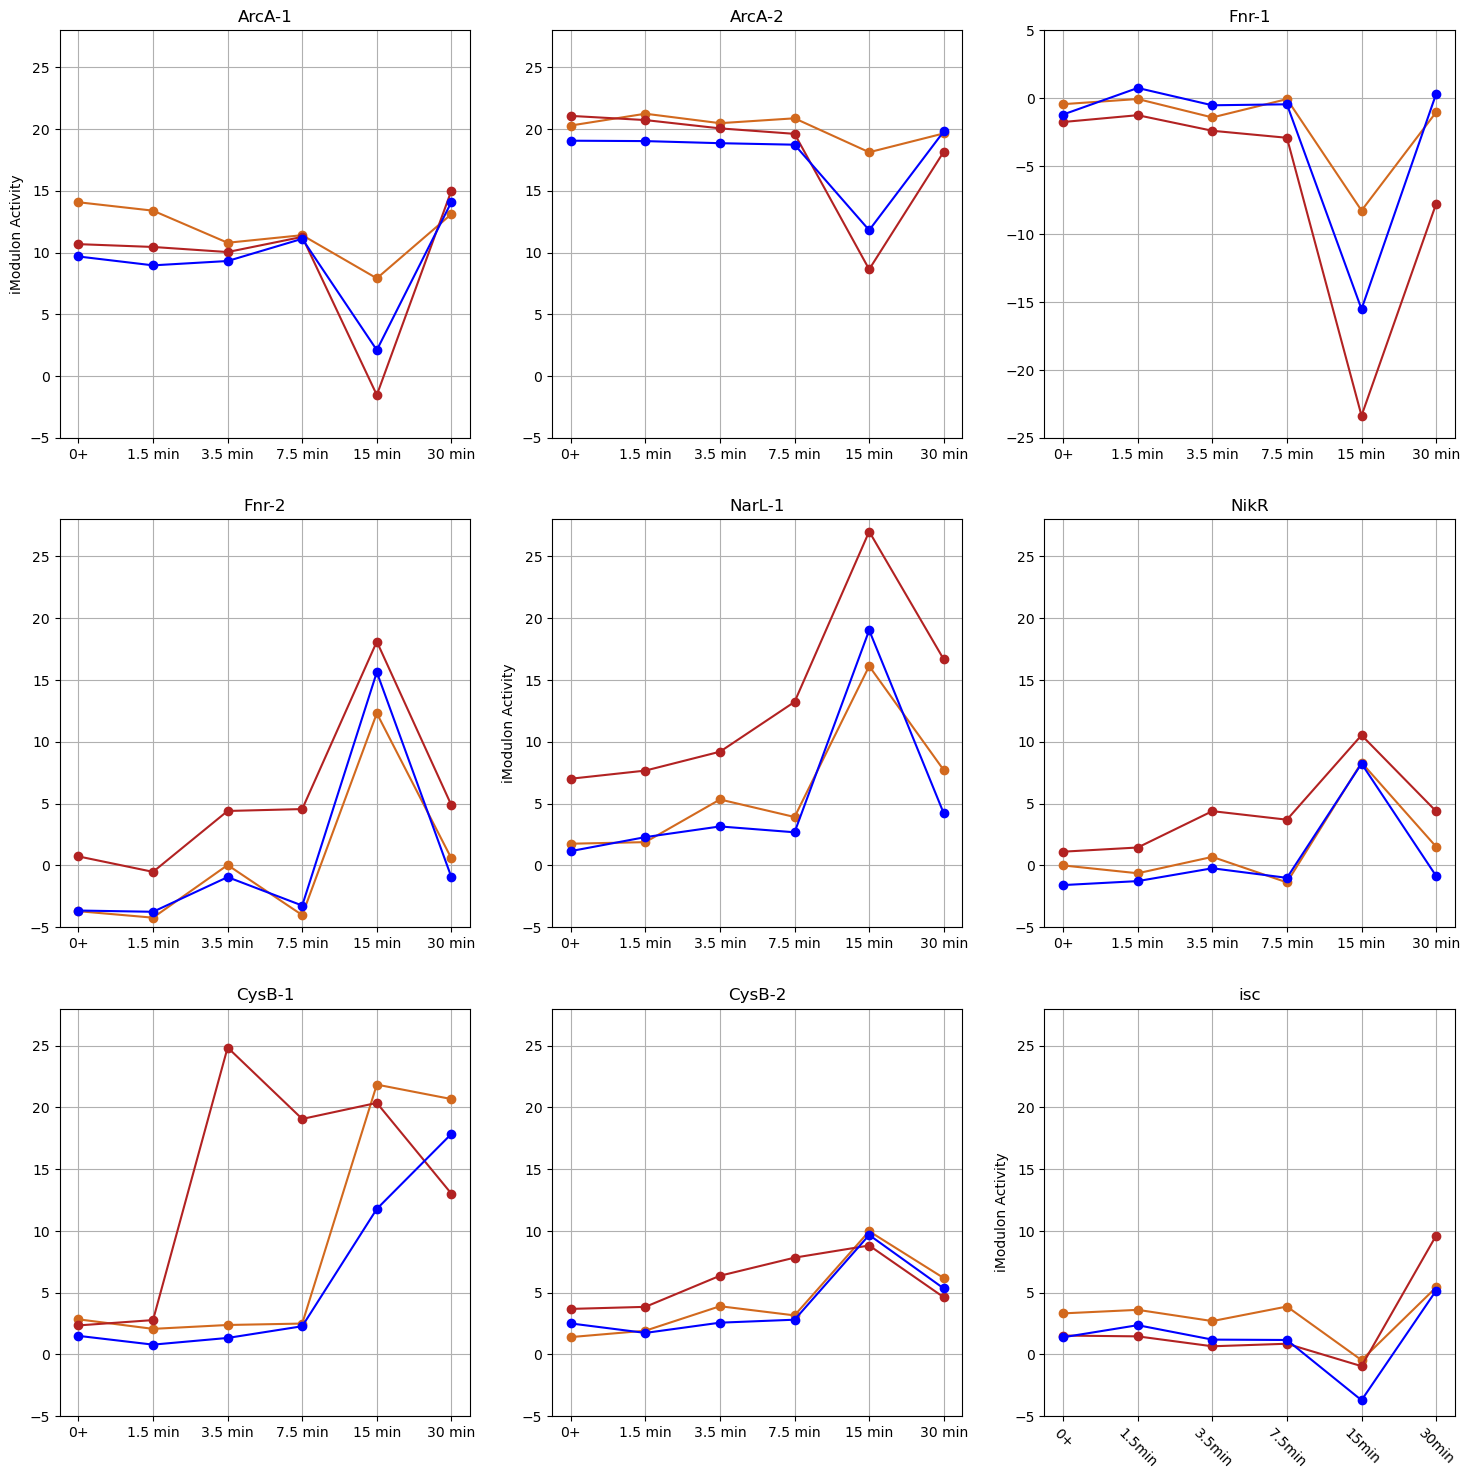

In [16]:
import matplotlib.gridspec as gridspec
# Create a figure object
fig = plt.figure(figsize=(18, 18))
xticks=['0+','1.5min','3.5min','7.5min','15min','30min']
# Define the grid layout
gs = gridspec.GridSpec(3, 3, width_ratios=[6, 6, 6], height_ratios=[6, 6, 6])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

ax4 = fig.add_subplot(gs[1, 0])  
ax5 = fig.add_subplot(gs[1, 1])  
ax6 = fig.add_subplot(gs[1, 2])

ax7 = fig.add_subplot(gs[2, 0])
ax8 = fig.add_subplot(gs[2, 1])
ax9 = fig.add_subplot(gs[2, 2])

ax1.plot(amp16_activity(ica_data,['ArcA-1']).T,'-o',color='chocolate')
ax1.plot(amp4_activity(ica_data,['ArcA-1']).T,'-o',color='firebrick')
ax1.plot(cipro_activity(ica_data,['ArcA-1']).T,'-o',color='blue')
# ax1.set_xticklabels(xticks,rotation=-45)
ax1.grid(True)
ax1.set_title('ArcA-1')
ax1.set_ylabel('iModulon Activity')
ax1.set_ylim(-5, 28)

ax2.plot(amp16_activity(ica_data,['ArcA-2']).T,'-o',color='chocolate')
ax2.plot(amp4_activity(ica_data,['ArcA-2']).T,'-o',color='firebrick')
ax2.plot(cipro_activity(ica_data,['ArcA-2']).T,'-o',color='blue')
# ax2.set_xticklabels(xticks,rotation=-45)
ax2.set_title('ArcA-2')
ax2.grid(True)
ax2.set_ylim(-5, 28)

ax3.plot(amp16_activity(ica_data,['Fnr-1']).T,'-o',color='chocolate')
ax3.plot(amp4_activity(ica_data,['Fnr-1']).T,'-o',color='firebrick')
ax3.plot(cipro_activity(ica_data,['Fnr-1']).T,'-o',color='blue')
# ax3.set_xticklabels(xticks,rotation=-45)
ax3.set_title('Fnr-1')
ax3.grid(True)
ax3.set_ylim(-25, 5)

ax4.plot(amp16_activity(ica_data,['Fnr-2']).T,'-o',color='chocolate')
ax4.plot(amp4_activity(ica_data,['Fnr-2']).T,'-o',color='firebrick')
ax4.plot(cipro_activity(ica_data,['Fnr-2']).T,'-o',color='blue')
# ax4.set_xticklabels(xticks,rotation=-45)
ax4.set_title('Fnr-2')
ax4.grid(True)
ax4.set_ylim(-5, 28)

ax5.plot(amp16_activity(ica_data,['NarL-1']).T,'-o',color='chocolate')
ax5.plot(amp4_activity(ica_data,['NarL-1']).T,'-o',color='firebrick')
ax5.plot(cipro_activity(ica_data,['NarL-1']).T,'-o',color='blue')
# ax5.set_xticklabels(xticks,rotation=-45)
ax5.grid(True)
ax5.set_title('NarL-1')
ax5.set_ylabel('iModulon Activity')
ax5.set_ylim(-5, 28)

ax6.plot(amp16_activity(ica_data,['NikR']).T,'-o',color='chocolate')
ax6.plot(amp4_activity(ica_data,['NikR']).T,'-o',color='firebrick')
ax6.plot(cipro_activity(ica_data,['NikR']).T,'-o',color='blue')
# ax6.set_xticklabels(xticks,rotation=-45)
ax6.set_title('NikR')
ax6.grid(True)
ax6.set_ylim(-5, 28)

ax7.plot(amp16_activity(ica_data,['CysB-1']).T,'-o',color='chocolate')
ax7.plot(amp4_activity(ica_data,['CysB-1']).T,'-o',color='firebrick')
ax7.plot(cipro_activity(ica_data,['CysB-1']).T,'-o',color='blue')
# ax7.set_xticklabels(xticks,rotation=-45)
ax7.set_title('CysB-1')
ax7.grid(True)
ax7.set_ylim(-5, 28)

ax8.plot(amp16_activity(ica_data,['CysB-2']).T,'-o',color='chocolate')
ax8.plot(amp4_activity(ica_data,['CysB-2']).T,'-o',color='firebrick')
ax8.plot(cipro_activity(ica_data,['CysB-2']).T,'-o',color='blue')
# ax8.set_xticklabels(xticks,rotation=-45)
ax8.set_title('CysB-2')
ax8.grid(True)
ax8.set_ylim(-5, 28)

ax9.plot(amp16_activity(ica_data,['isc']).T,'-o',color='chocolate')
ax9.plot(amp4_activity(ica_data,['isc']).T,'-o',color='firebrick')
ax9.plot(cipro_activity(ica_data,['isc']).T,'-o',color='blue')
ax9.set_xticklabels(xticks,rotation=-45)
ax9.grid(True)
ax9.set_title('isc')
ax9.set_ylabel('iModulon Activity')
ax9.set_ylim(-5, 28)

## Figure 5

<AxesSubplot:xlabel='Gene Start', ylabel='Rcs-1 Gene Weight'>

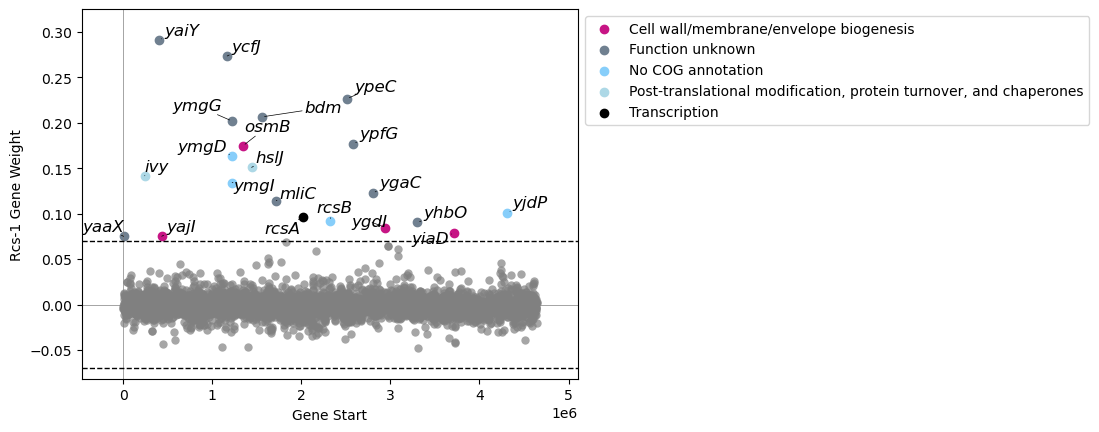

In [17]:
plot_gene_weights(ica_data,'Rcs-1',show_labels=True)

<AxesSubplot:xlabel='Gene Start', ylabel='LexA Gene Weight'>

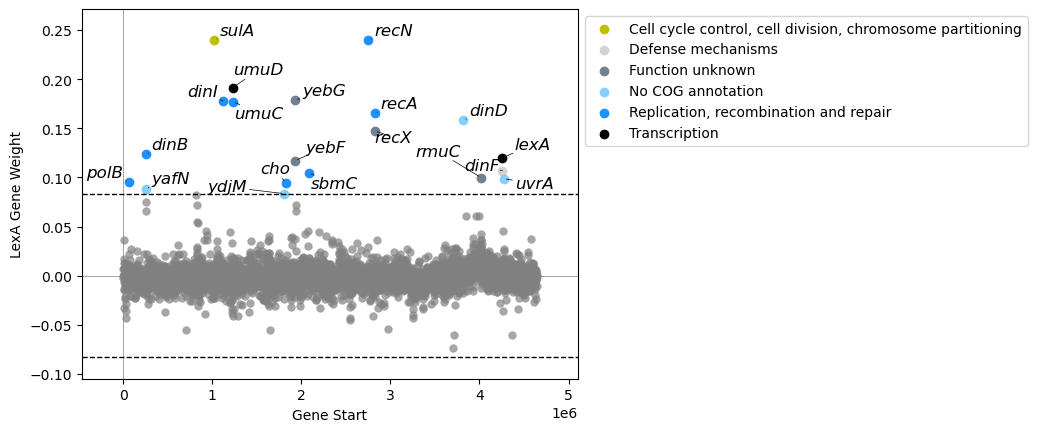

In [18]:
plot_gene_weights(ica_data,'LexA',show_labels=True)

In [19]:
pilot_index = ica_data.sample_table[ica_data.sample_table.project=='pilot'].index

In [20]:
def activity_barplot(imod):
    cmap = plt.cm.get_cmap("Paired")
    colors = cmap(np.linspace(0, 1, 3))
    fig,ax = plt.subplots(figsize=[10,5])
    seperators = []
    dots = []

    group_labels = ['0+', '1.5min', '3.5min', '7.5min', '15min', '30min']
    labels = group_labels * 3 

    label_count = 0

    x_positions = np.arange(len(labels))

    for i, (condition, group) in enumerate(ica_data.sample_table.loc[pilot_index].groupby('condition')):
        values = ica_data.A[group.index].loc[imod] 
        dots.append(list(values))  

        color = colors[(label_count // 6) % len(colors)]
        ax.bar(x_positions[label_count], values.mean(), width=0.8, color=color)
        label_count += 1 


    sep_pos = -.5
    dot_pos = 0

    for condition in dots:
        for dot in condition:
            ax.plot(dot_pos,dot,"ko")
        dot_pos+=1

    non_mifH = ica_data.A.loc[imod]
    non_mifH = non_mifH.drop(list(ica_data.sample_table.loc[ica_data.sample_table["project"]=='pilot'].index))
    mean = non_mifH.mean()
    std_dev = non_mifH.std()

    ylimits = ax.get_ylim()
    ax.set_xlim([-.5,label_count+.5])
    ax.plot(list(ax.get_xlim()),[0,0],color="gray")
    ax.set_ylim(ylimits)
    ax.set_ylabel(str(imod)+" iModulon Activity",fontsize=15)

    seperators = [6,6,6]
    for cord in seperators:
        sep_pos+=cord
        ax.plot([sep_pos,sep_pos],ylimits,color="gray")

    custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                    Line2D([0], [0], color=colors[1], lw=4),
                    Line2D([0], [0], color=colors[2], lw=4)]
    ax.legend(custom_lines, ['amp 1/16x', 'amp 1/4x', 'cipro'], 
                  bbox_to_anchor=(1, 1), loc='upper left', fontsize=14)

    plt.xticks(x_positions, labels, fontsize=12, rotation=45, ha='right')
    plt.title(str(imod)+" iModulon Activity")
    for label in ax.get_xmajorticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment("right")

<AxesSubplot:ylabel='Rcs-1 iModulon\nActivity'>

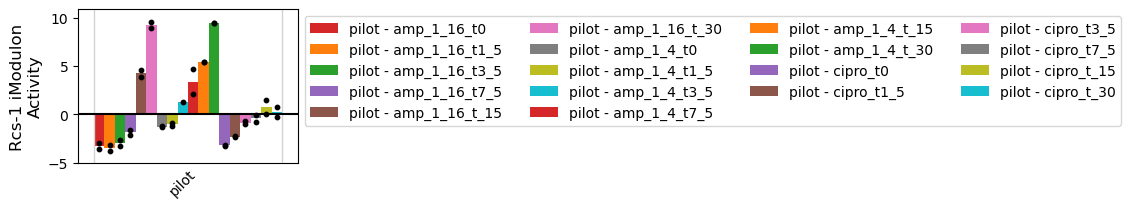

In [21]:
plot_activities(ica_data,'Rcs-1',projects='pilot')

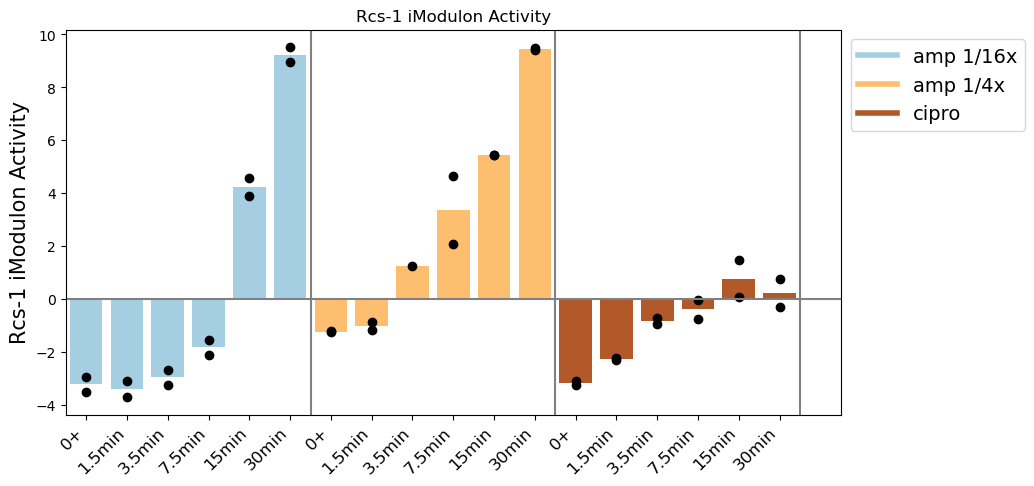

In [22]:
activity_barplot('Rcs-1')

<AxesSubplot:ylabel='LexA iModulon\nActivity'>

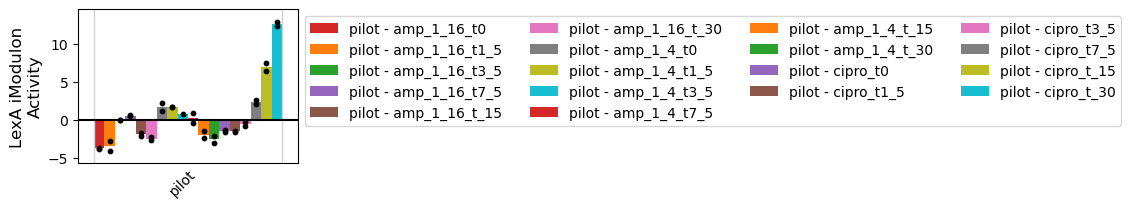

In [23]:
plot_activities(ica_data,'LexA',projects='pilot')

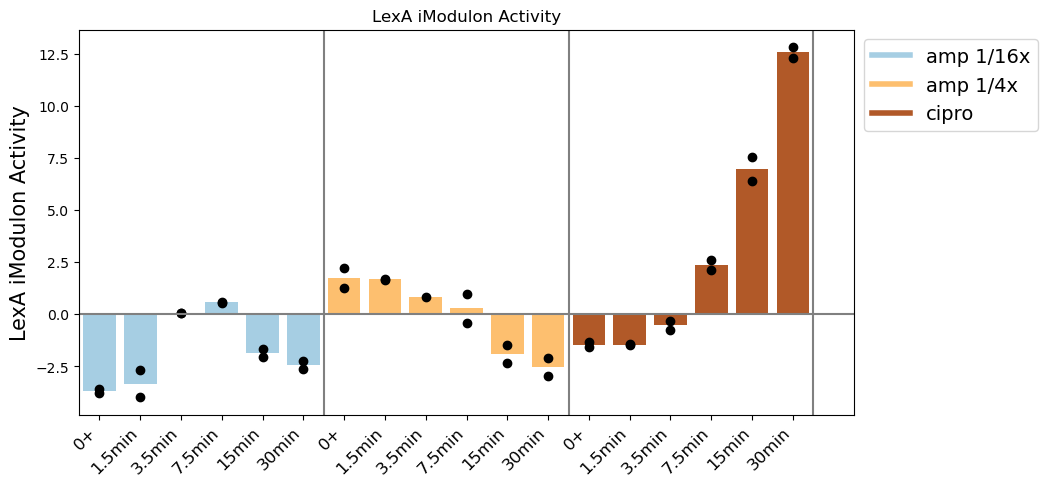

In [24]:
activity_barplot('LexA')

In [25]:
lexa_imod = set(ica_data.view_imodulon('LexA').index)
lexa_regulon = set(ica_data.trn[ica_data.trn.regulator=='LexA'].gene_id)

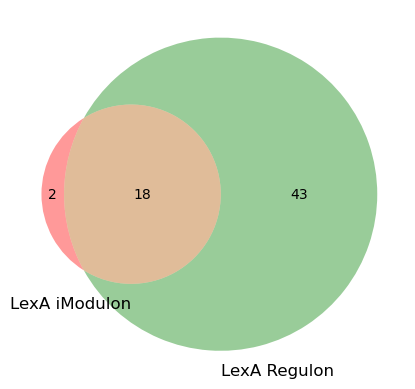

In [26]:
venn2([lexa_imod,lexa_regulon],('LexA iModulon','LexA Regulon'))

# Supplements

## SI Figure 1

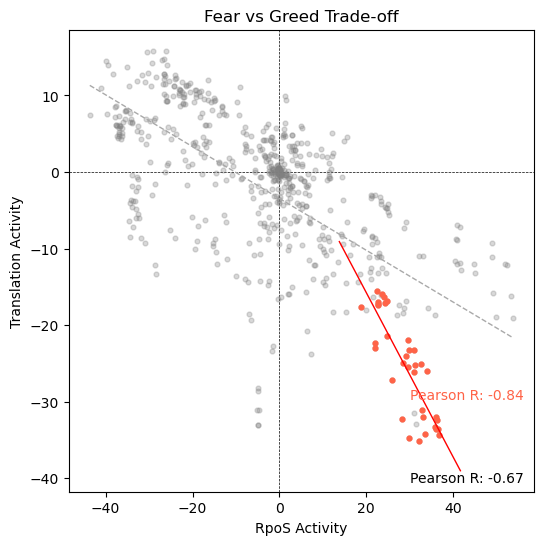

In [27]:
X_IM = 'RpoS'
Y_IM = 'Translation'


_, ax = plt.subplots(figsize=(6, 6))

ax.axvline(0, linestyle='--', color='black', zorder=-1, linewidth=0.5)
ax.axhline(0, linestyle='--', color='black', zorder=-1, linewidth=0.5)

x_p1k_acts, y_p1k_acts = ica_data.A.loc[X_IM], ica_data.A.loc[Y_IM]

ax.scatter(x_p1k_acts, y_p1k_acts, c='gray', s=12, alpha=0.3)

all_slope, all_intercept = np.polyfit(x_p1k_acts, y_p1k_acts, 1)
x_range = np.linspace(x_p1k_acts.min(), x_p1k_acts.max(), 100)
ax.plot(x_range, all_slope * x_range + all_intercept, color='darkgray', linestyle='--', linewidth=1, label='All Samples Fit')

pearson_r, p = pearsonr(x_p1k_acts, y_p1k_acts)
ax.text(0.98, 0.02, f'Pearson R: {pearson_r:.2f}', transform=ax.transAxes, ha='right')

proj_A = ica_data.A[pilot_index]
x_proj_acts, y_proj_acts = proj_A.loc[X_IM], proj_A.loc[Y_IM]
ax.scatter(x_proj_acts, y_proj_acts, c='tomato', s=12)


proj_slope, proj_intercept = np.polyfit(x_proj_acts, y_proj_acts, 1)
x_proj_range = np.linspace(x_proj_acts.min()-5, x_proj_acts.max()+5, 100)  
ax.plot(x_proj_range, proj_slope * x_proj_range + proj_intercept, 
        color='red', linestyle='-', linewidth=1, label='Project Samples Fit')

proj_pearson_r, p = pearsonr(x_proj_acts, y_proj_acts)
ax.text(0.98, 0.2, f'Pearson R: {proj_pearson_r:.2f}', transform=ax.transAxes, ha='right', color='tomato')

ax.set_xlabel(f'{X_IM} Activity', fontsize=10)
ax.set_ylabel(f'{Y_IM} Activity', fontsize=10)
ax.set_title('Fear vs Greed Trade-off')
None

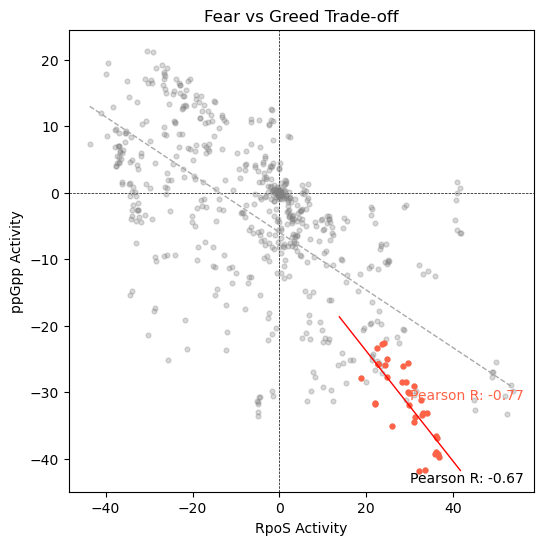

In [28]:
X_IM = 'RpoS'
Y_IM = 'ppGpp'


_, ax = plt.subplots(figsize=(6, 6))

ax.axvline(0, linestyle='--', color='black', zorder=-1, linewidth=0.5)
ax.axhline(0, linestyle='--', color='black', zorder=-1, linewidth=0.5)

x_p1k_acts, y_p1k_acts = ica_data.A.loc[X_IM], ica_data.A.loc[Y_IM]

ax.scatter(x_p1k_acts, y_p1k_acts, c='gray', s=12, alpha=0.3)

all_slope, all_intercept = np.polyfit(x_p1k_acts, y_p1k_acts, 1)
x_range = np.linspace(x_p1k_acts.min(), x_p1k_acts.max(), 100)
ax.plot(x_range, all_slope * x_range + all_intercept, color='darkgray', linestyle='--', linewidth=1, label='All Samples Fit')

pearson_r, p = pearsonr(x_p1k_acts, y_p1k_acts)
ax.text(0.98, 0.02, f'Pearson R: {pearson_r:.2f}', transform=ax.transAxes, ha='right')

proj_A = ica_data.A[pilot_index]
x_proj_acts, y_proj_acts = proj_A.loc[X_IM], proj_A.loc[Y_IM]
ax.scatter(x_proj_acts, y_proj_acts, c='tomato', s=12)


proj_slope, proj_intercept = np.polyfit(x_proj_acts, y_proj_acts, 1)
x_proj_range = np.linspace(x_proj_acts.min()-5, x_proj_acts.max()+5, 100)  
ax.plot(x_proj_range, proj_slope * x_proj_range + proj_intercept, 
        color='red', linestyle='-', linewidth=1, label='Project Samples Fit')

proj_pearson_r, p = pearsonr(x_proj_acts, y_proj_acts)
ax.text(0.98, 0.2, f'Pearson R: {proj_pearson_r:.2f}', transform=ax.transAxes, ha='right', color='tomato')

ax.set_xlabel(f'{X_IM} Activity', fontsize=10)
ax.set_ylabel(f'{Y_IM} Activity', fontsize=10)
ax.set_title('Fear vs Greed Trade-off')
None

## SI Figure 2

In [29]:
ica_data.imodulon_table

regulator        pvalue        qvalue  precision    recall  \
SSW SNPs                NaN           NaN           NaN        NaN       NaN   
Fur-1                   Fur  1.685496e-44  5.393588e-43   0.820513  0.250000   
Crp-2                   NaN           NaN           NaN        NaN       NaN   
Membrane                NaN           NaN           NaN        NaN       NaN   
RpoH                   RpoH  1.808843e-41  5.245645e-40   0.815789  0.219858   
...                     ...           ...           ...        ...       ...   
Unchar_16               NaN           NaN           NaN        NaN       NaN   
dsrA                   dsrA  3.439163e-14  1.719582e-13   1.000000  0.454545   
nitrate_reductase      RstA  1.706395e-07  9.385174e-07   0.500000  0.300000   
nuo                    ryhB  5.733128e-16  8.599692e-15   0.818182  0.147541   
Unchar_17               Mlc  6.204798e-10  2.419871e-08   0.217391  0.500000   

                    f1score    TP  regulon_size  imodulon_size  n_regs  \
SSW SNPs                NaN   NaN           NaN            137     NaN   
Fur-1              0.383234  32.0         128.0             39     1.0   
Crp-2                   NaN   NaN           NaN             52     NaN   
Membrane                NaN   NaN           NaN             23     NaN   
RpoH               0.346369  31.0         141.0             38     1.0   
...                     ...   ...           ...            ...     ...   
Unchar_16               NaN   NaN           NaN              5     NaN   
dsrA               0.625000   5.0          11.0              5     1.0   
nitrate_reductase  0.375000   3.0          10.0              6     1.0   
nuo                0.250000   9.0          61.0             11     1.0   
Unchar_17          0.303030   5.0          10.0             23     1.0   

                   pilot_exp_var           category  explained_variance  \
SSW SNPs                0.003090        ALE Effects            0.003780   
Fur-1                   0.021712  Metal Homeostasis            0.018648   
Crp-2                   0.002387  Carbon Metabolism            0.013845   
Membrane                0.000159    Envelope Stress            0.003153   
RpoH                    0.009606  Temperature Shock            0.009124   
...                          ...                ...                 ...   
Unchar_16               0.000313    Uncharacterized            0.001758   
dsrA                    0.001744  Carbon Metabolism            0.004163   
nitrate_reductase       0.004215  Energy Metabolism            0.002675   
nuo                     0.001649  Energy Metabolism            0.003735   
Unchar_17               0.004033    Uncharacterized            0.003397   

                               phase  
SSW SNPs                     Primary  
Fur-1                        Primary  
Crp-2                       Tertiary  
Membrane                     Primary  
RpoH                Primary,Tertiary  
...                              ...  
Unchar_16             Non-responsive  
dsrA                Primary,Tertiary  
nitrate_reductase  Primary,Secondary  
nuo                          Primary  
Unchar_17                    Primary  

[132 rows x 14 columns]

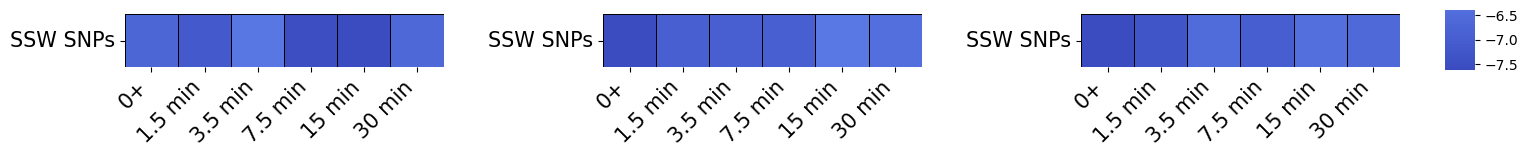

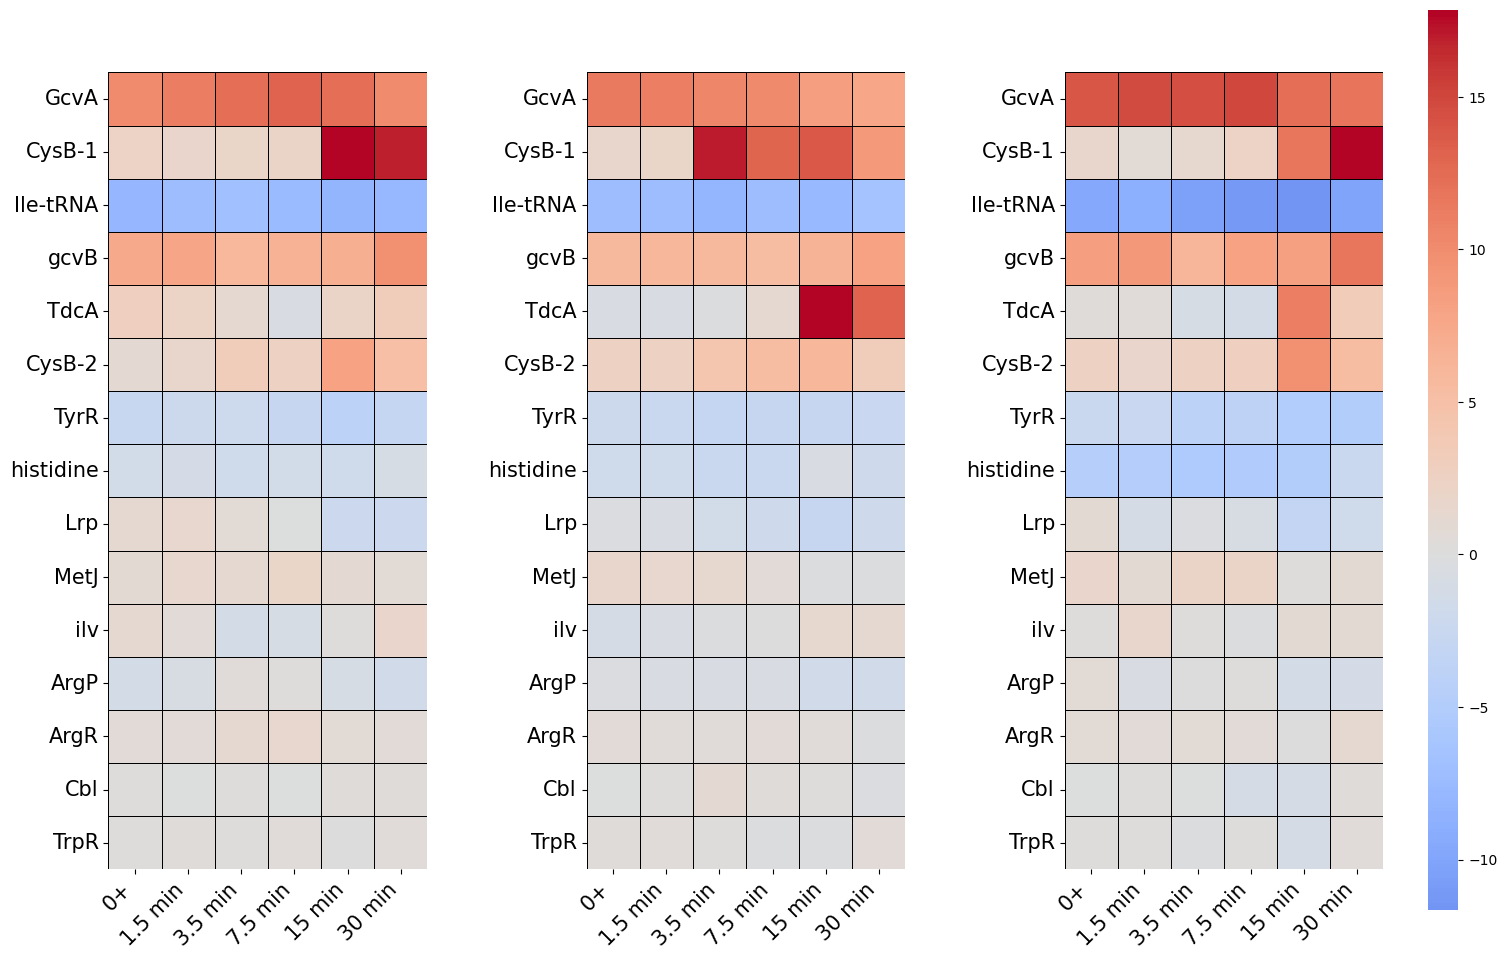

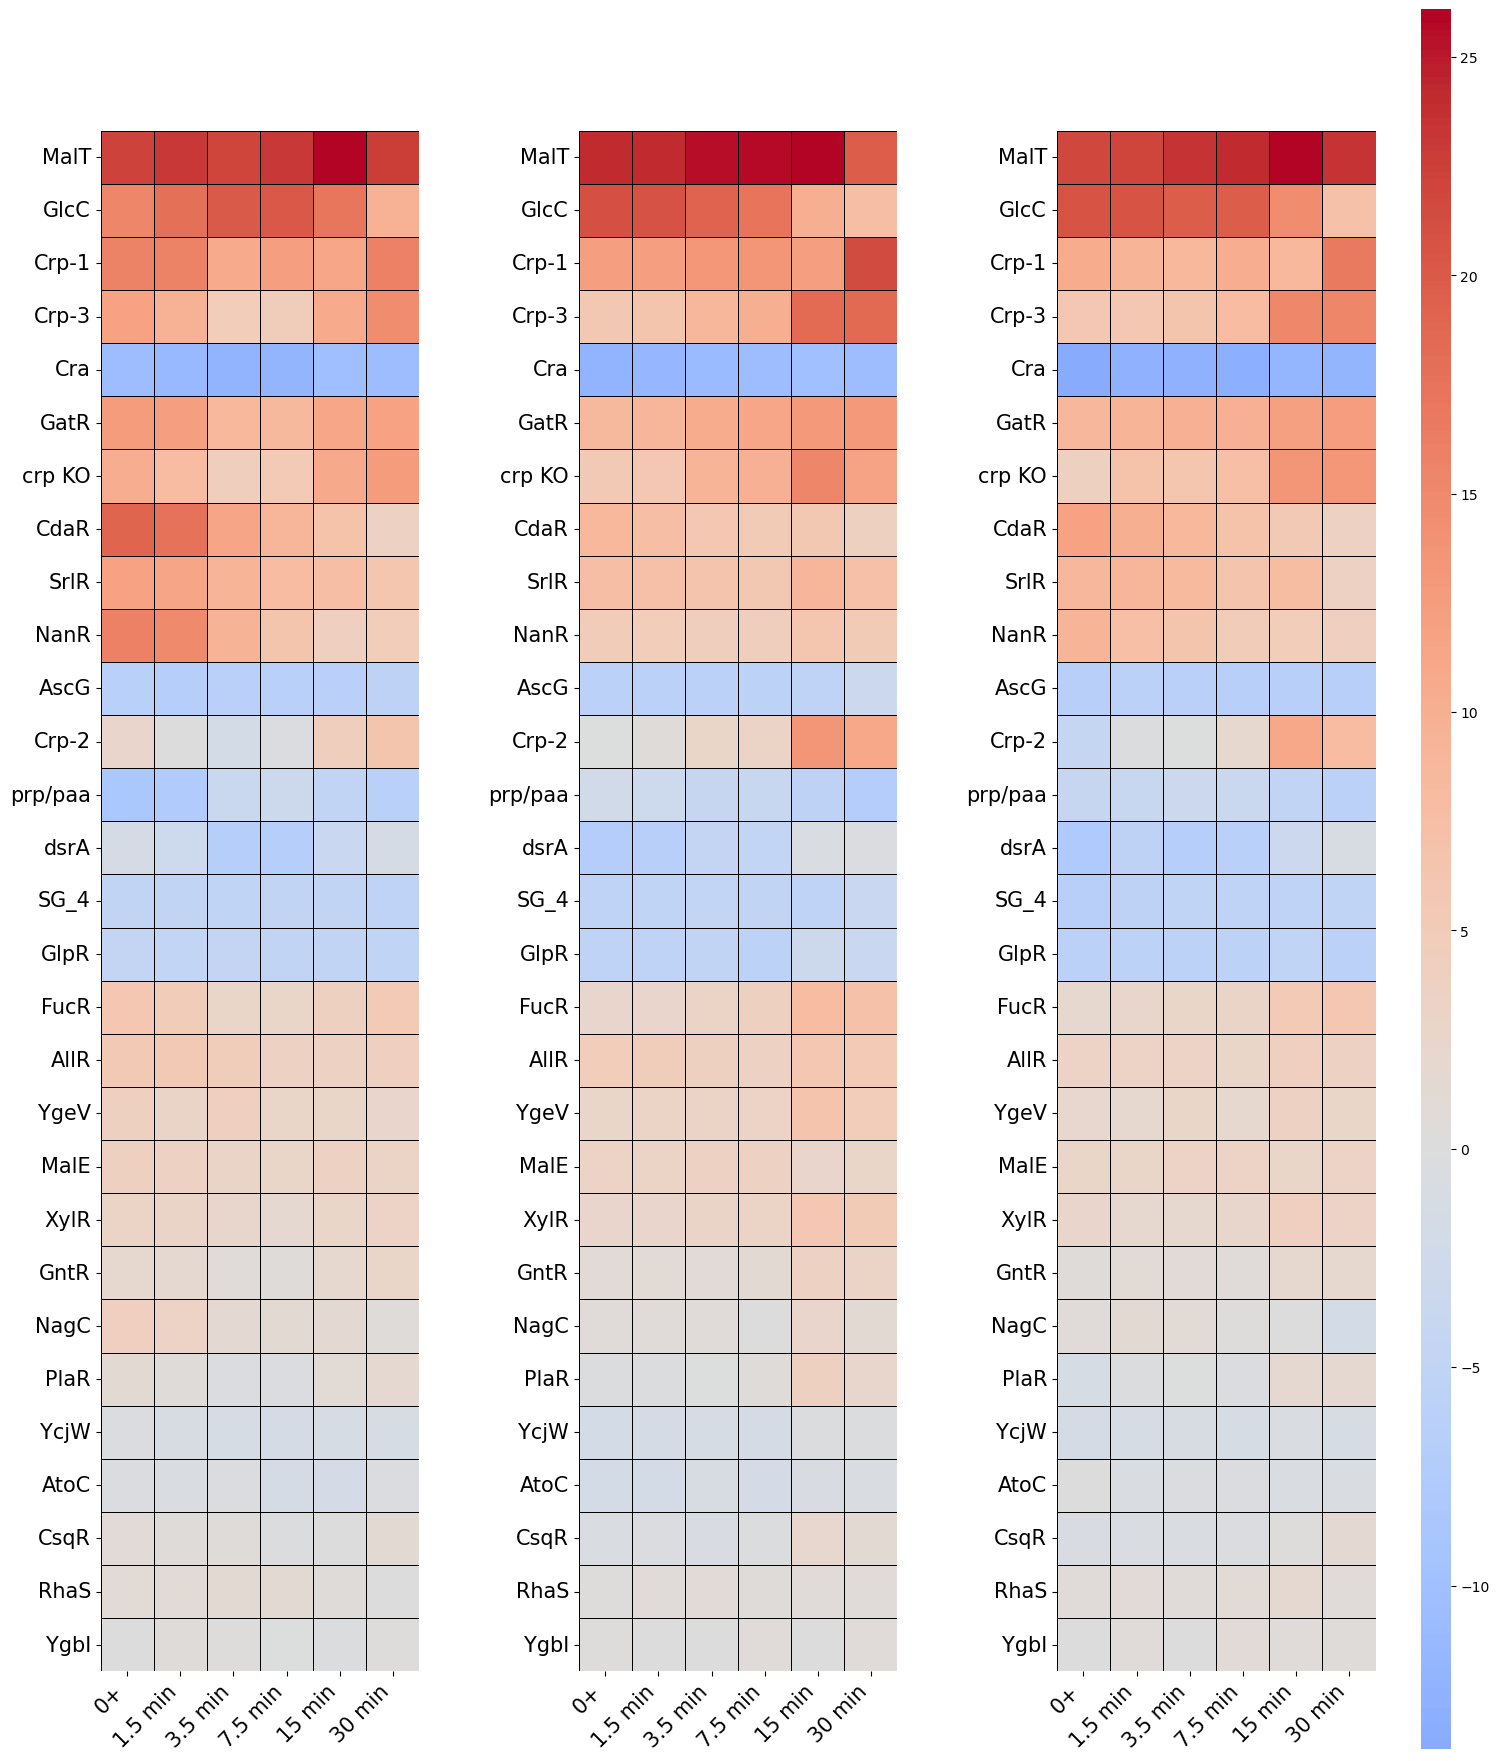

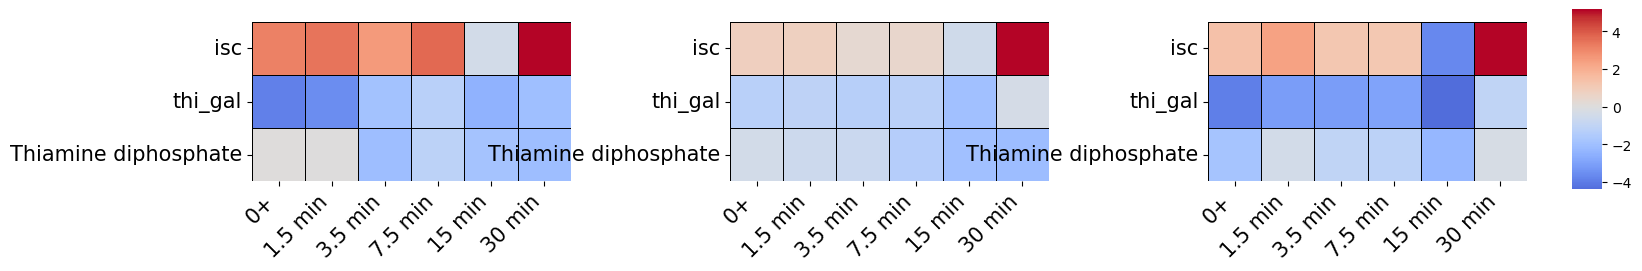

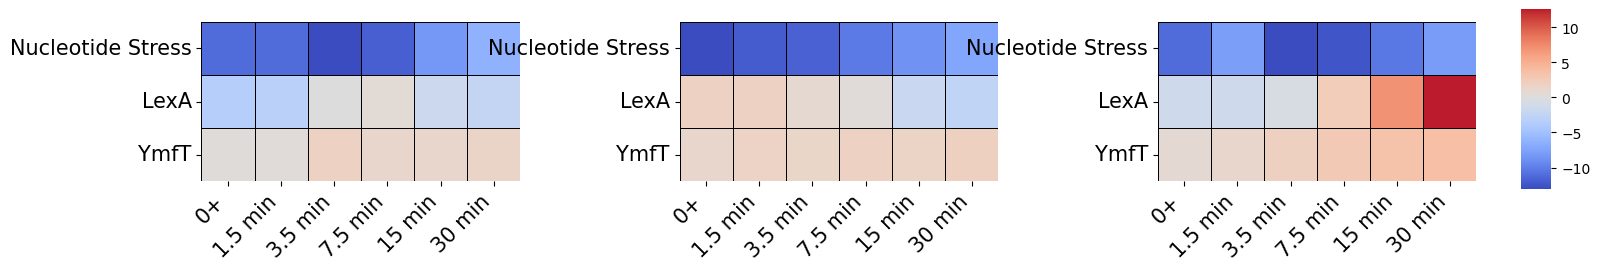

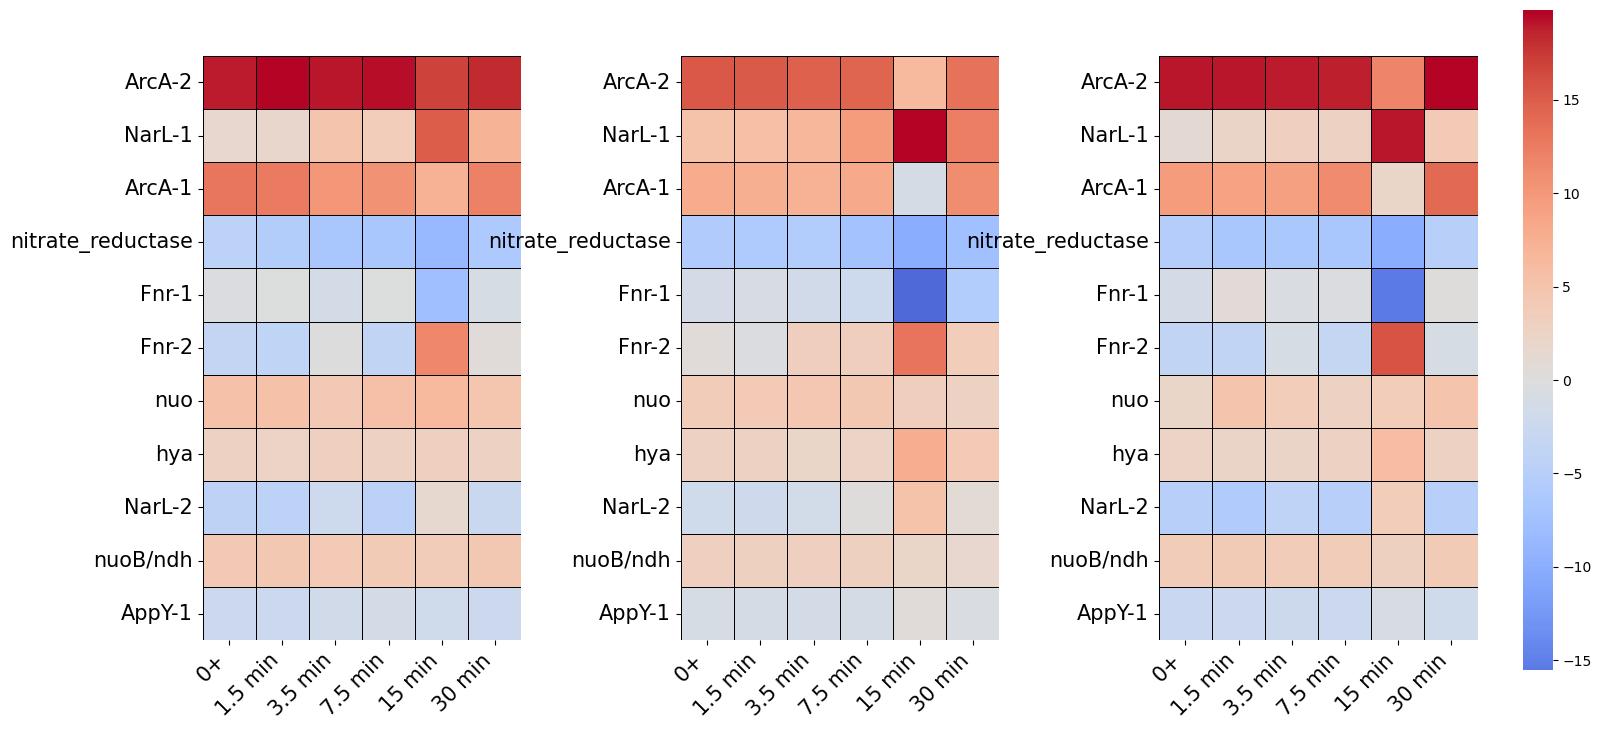

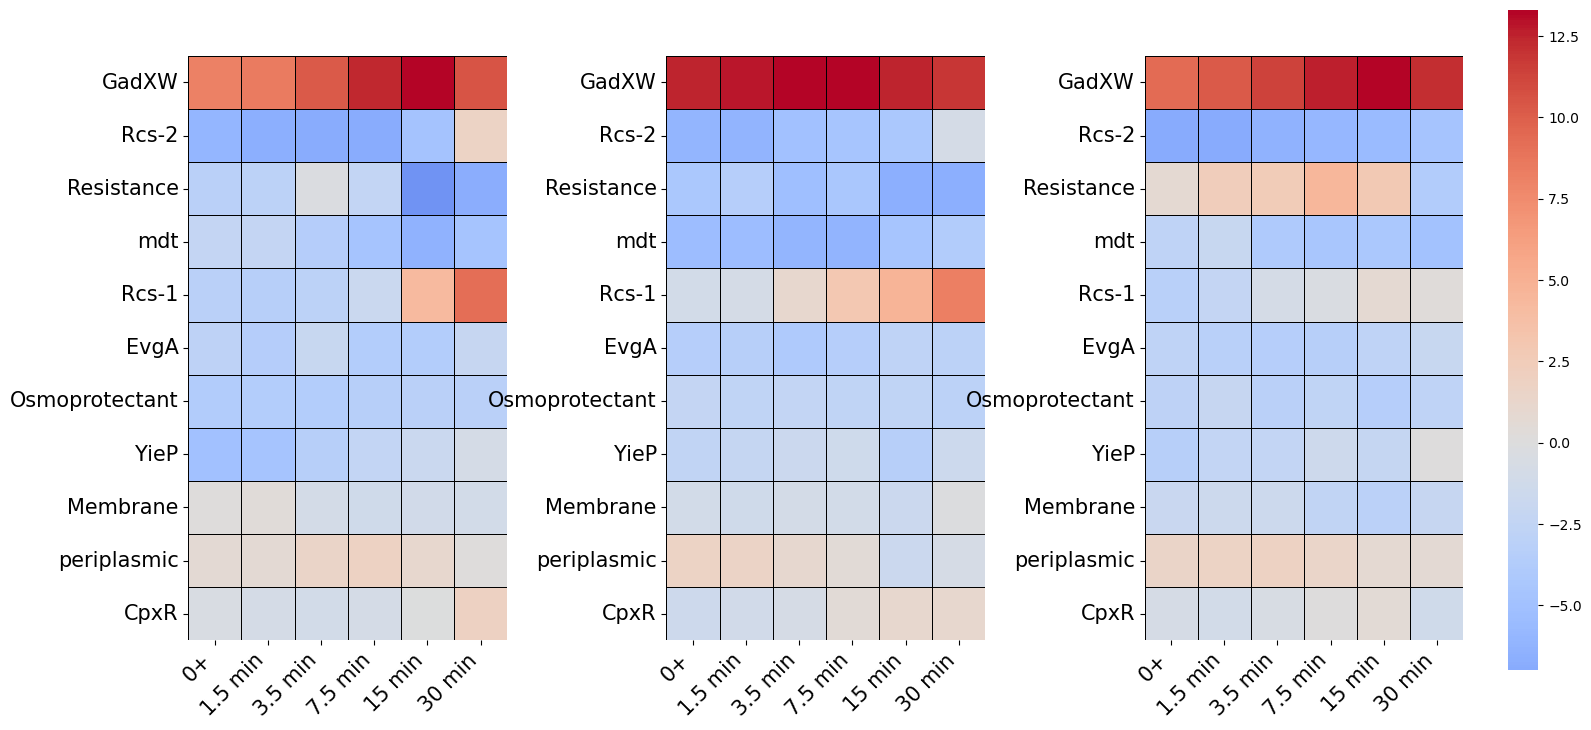

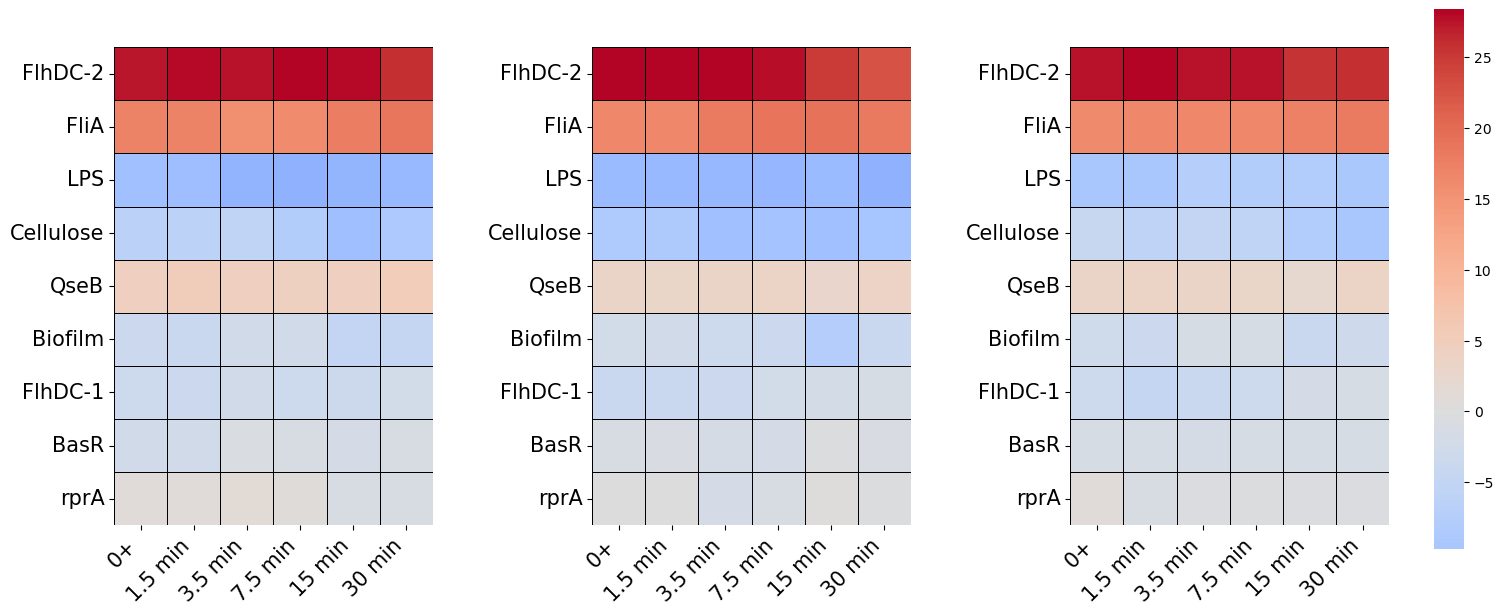

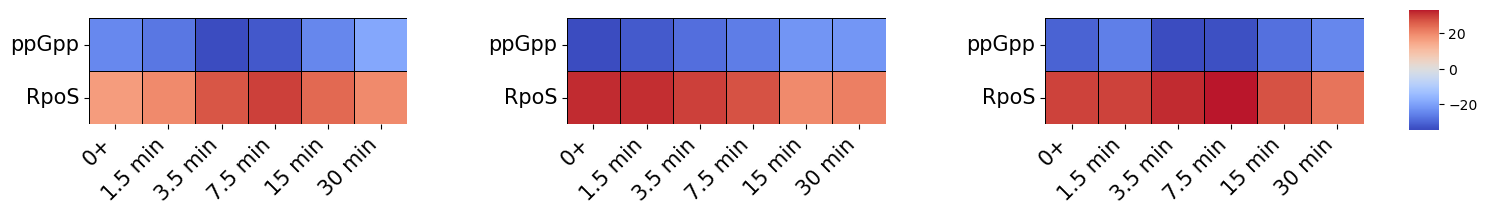

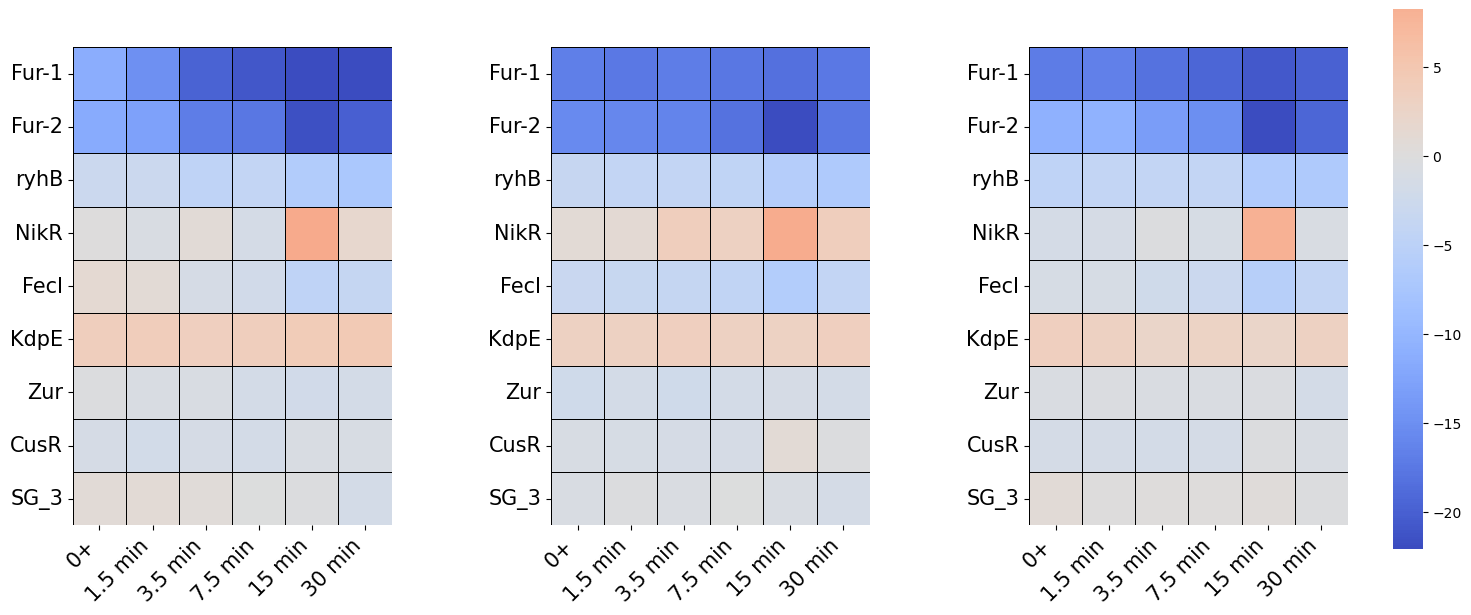

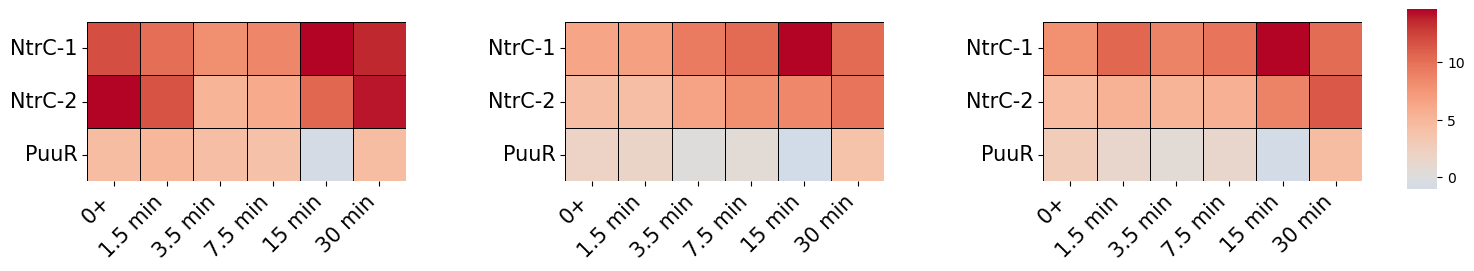

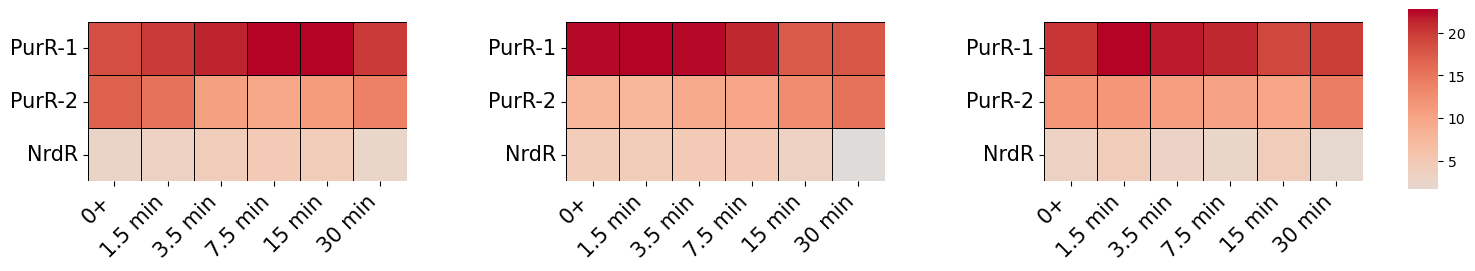

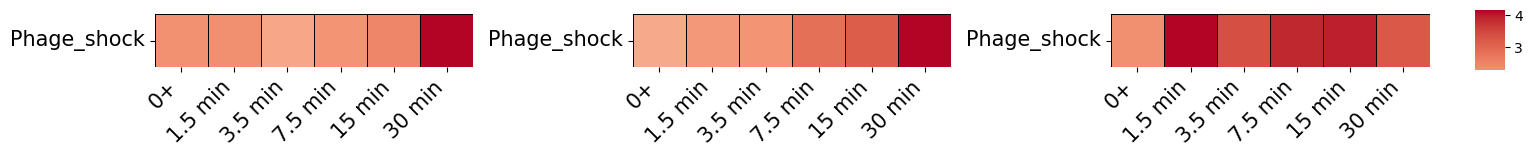

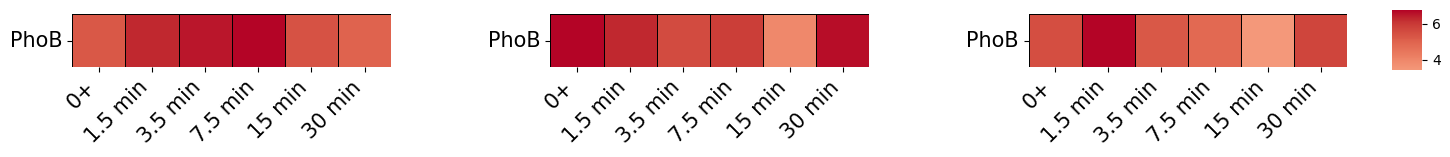

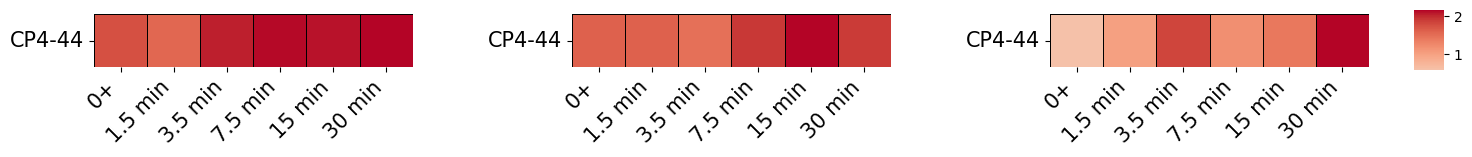

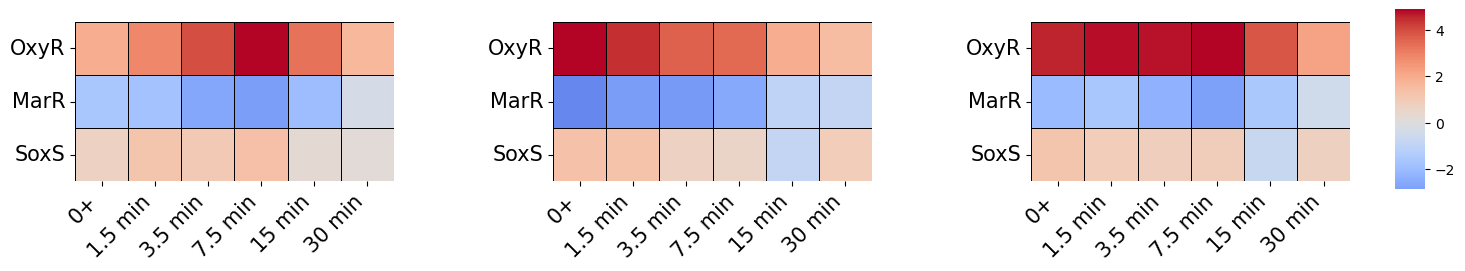

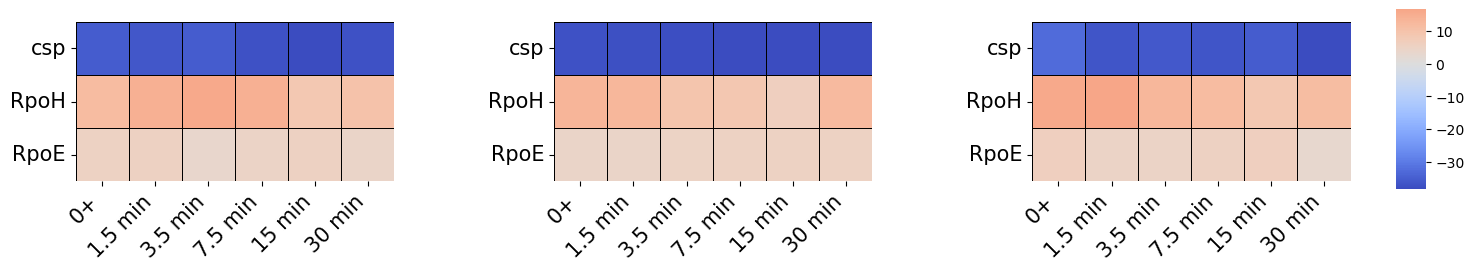

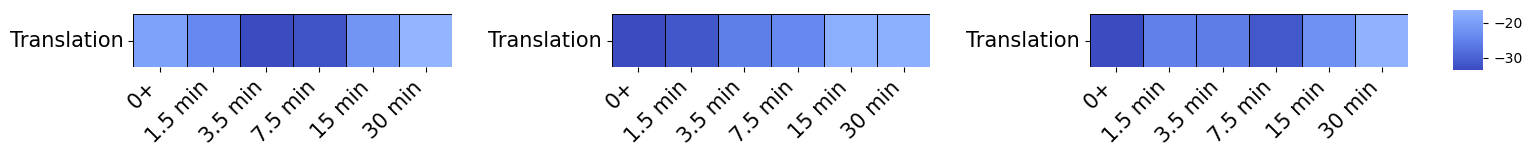

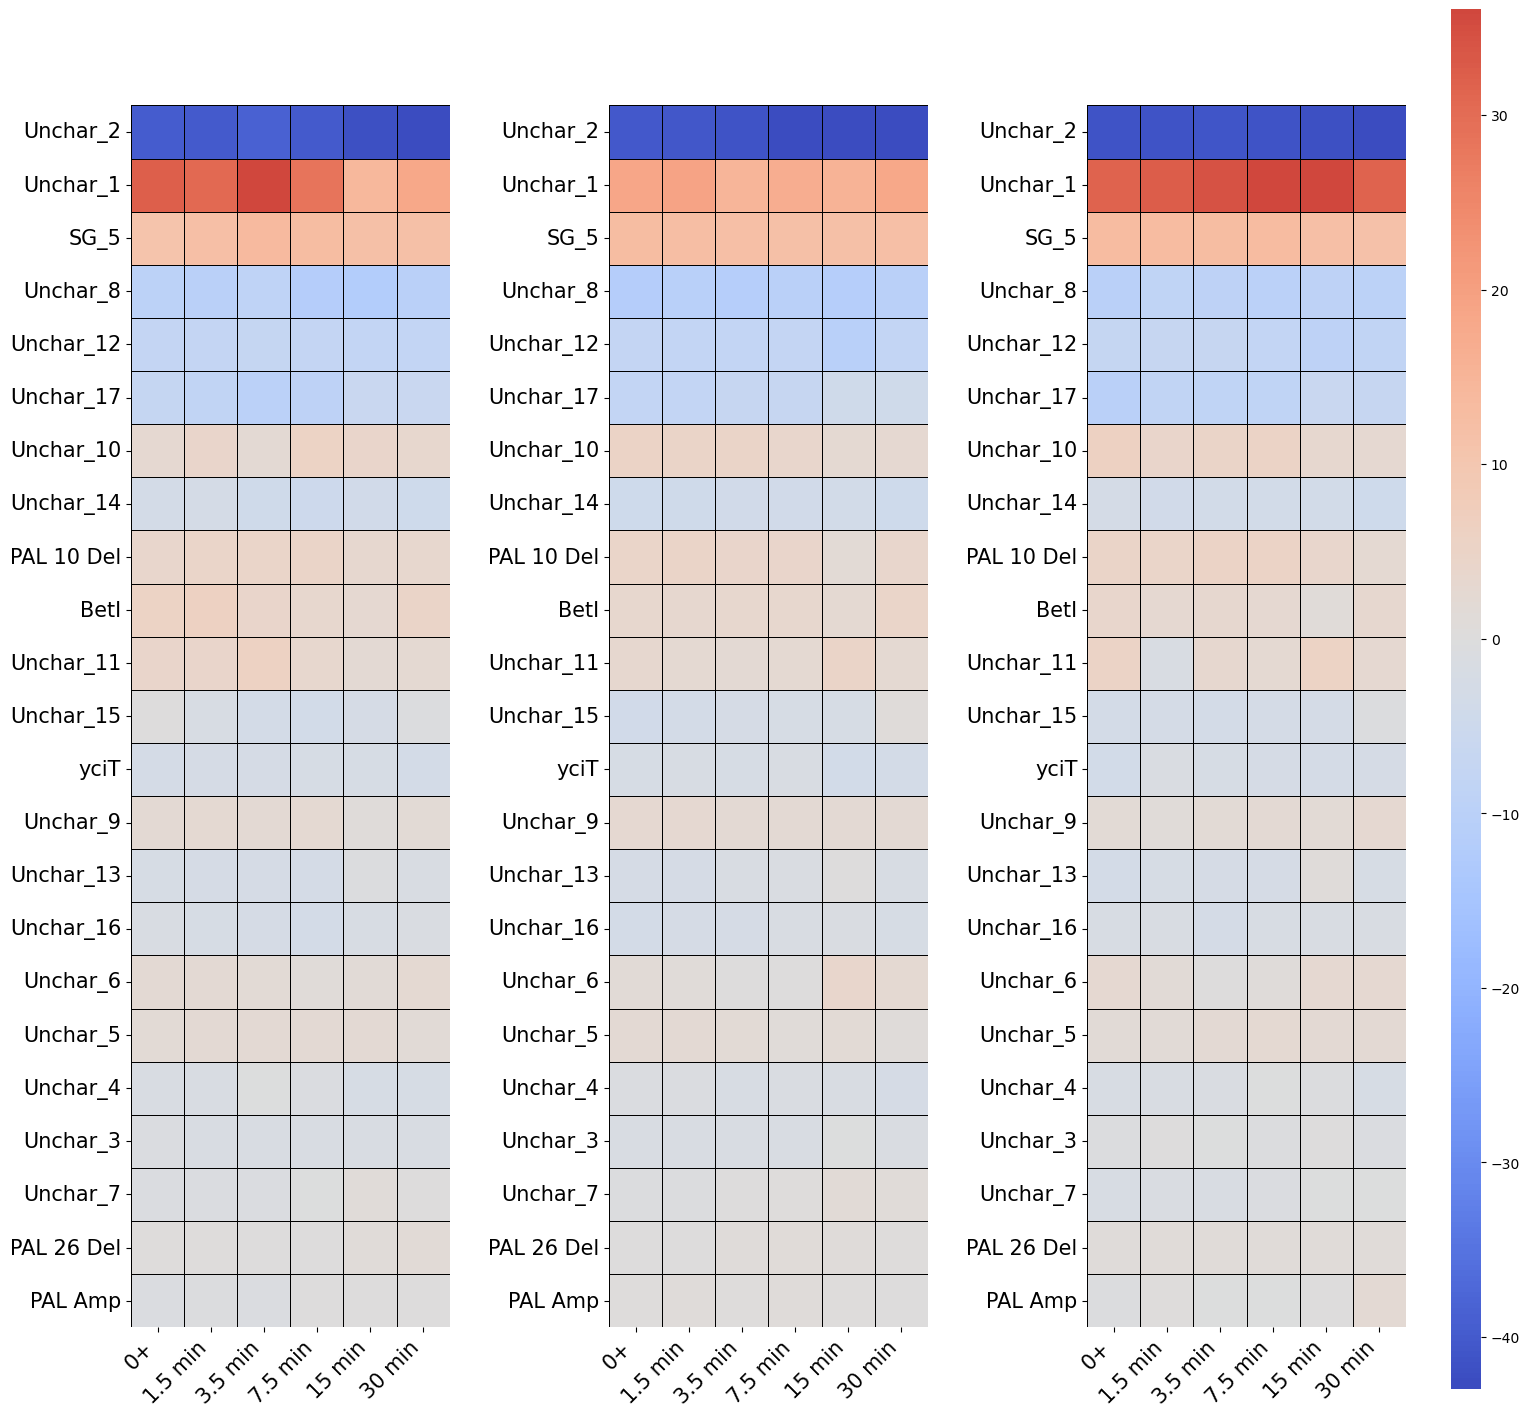

In [30]:
for cat in np.unique(ica_data.imodulon_table.category):
    cat_imod_table = ica_data.imodulon_table[ica_data.imodulon_table.category==cat].sort_values('pilot_exp_var',
                                                                                               ascending=False)
    imods = cat_imod_table.index
    time_series_heatmap(imods)

## SI Figure 3

In [31]:
mic_data = '../interim/Keio KO MIC_041825_29-Apr-2025 10-01-22.xlsx'

In [32]:
def format_df_with_replicates(raw_df_path, plate_num, num_rows, rows_conc, strain_cols, strain_reps):
    
    df = pd.read_excel(raw_df_path,
                       sheet_name='Plate '+ str(plate_num) + ' - Raw Data',
                       header=1)

    df['Time(Hours)'] = [i * 20 / 60 for i in range(num_rows)]
    df = df.drop(columns=['Time'])
    df = df.set_index('Time(Hours)')
    df = df[df.index <= 24]

    # Averaged dataframe
    average_df = pd.DataFrame(index=df.index,
                              columns=pd.MultiIndex.from_product([strain_cols.keys(), rows_conc.values()]))

    # Long-form replicate-level dataframe
    long_data = []

    for strain, start_col in strain_cols.items():
        n_reps = strain_reps[strain]
        for row_letter, conc_label in rows_conc.items():
            for rep in range(n_reps):
                col_name = row_letter + str(start_col + rep)
                if col_name in df.columns:
                    od_series = df[col_name]
                    long_data.append({
                        'Time': df.index,
                        'OD': od_series.values,
                        'Strain': strain,
                        'Concentration': conc_label,
                        'Replicate': rep + 1
                    })
            # Compute average if all columns exist
            cols = [row_letter + str(start_col + i) for i in range(n_reps) if row_letter + str(start_col + i) in df.columns]
            if cols:
                average_df.loc[:, (strain, conc_label)] = df[cols].mean(axis=1)

    # Convert list of dicts to long DataFrame
    long_df = pd.DataFrame([
        {'Time': t, 'OD': od, 'Strain': d['Strain'], 'Concentration': d['Concentration'], 'Replicate': d['Replicate']}
        for d in long_data for t, od in zip(d['Time'], d['OD'])
    ])

    return average_df, long_df

In [33]:
def extract_mic_per_replicate(long_df, timepoint=20.0, od_threshold=0.15):
    mic_results = []

    # Subset to desired timepoint
    df_20h = long_df[long_df['Time'] == timepoint].copy()

    # Convert concentration labels to string for sorting and mapping
    df_20h['Concentration'] = df_20h['Concentration'].astype(str)

    # Group by strain and replicate
    grouped = df_20h.groupby(['Strain', 'Replicate'])

    for (strain, rep), group in grouped:
        # Sort concentrations from low to high
        sorted_group = group.sort_values(
            'Concentration',
            key=lambda x: conc_sort_key(x),
            ascending=True
        )

        # MIC = first concentration where OD is below threshold
        for _, row in sorted_group.iterrows():
            if row['OD'] < od_threshold:
                mic_results.append({
                    'Strain': strain,
                    'Replicate': rep,
                    'MIC': row['Concentration']
                })
                break
        else:
            # If no concentration inhibited growth
            mic_results.append({
                'Strain': strain,
                'Replicate': rep,
                'MIC': '>max'
            })

    return pd.DataFrame(mic_results)

In [34]:
def conc_sort_key(x):
    order = {
        '0': 0,
        '1': 1, '2': 2, '3': 3, '4': 4,
        '5': 5, '6': 6, '8': 7
    }
    return [order.get(str(v), 999) for v in x]

In [35]:
label_to_ugml = {
    '0': 0.0, '1': 1.0, '2': 2.0, '3': 3.0,
    '4': 4.0, '5': 5.0, '6': 6.0, '8': 8.0,
}

In [36]:
average_df1, long_df1 = format_df_with_replicates(mic_data,
                                                plate_num = 1,
                                                num_rows = 217,
                                                rows_conc = {'A':'8','B':'6','C':'5','D':'4','E':'3','F':'2','G':'1','H':'0'},
                                                strain_cols = {'BW':1,'yaiY':4,'ycfJ':7,'ypeC':10},
                                                strain_reps = {'BW':3,'yaiY':3,'ycfJ':3,'ypeC':3})
mic_df1 = extract_mic_per_replicate(long_df1)
mic_df1 = mic_df1[mic_df1['MIC'] != '>max'].copy()
mic_df1['MIC_ugml'] = mic_df1['MIC'].map(label_to_ugml).astype(float)

In [37]:
average_df2, long_df2 = format_df_with_replicates(mic_data,
                                                plate_num = 2,
                                                num_rows = 217,
                                                rows_conc = {'A':'8','B':'6','C':'5','D':'4','E':'3','F':'2','G':'1','H':'0'},
                                                strain_cols = {'ymgG':1,'ypfG':4,'ymgD':7,'ygaC':10},
                                                strain_reps = {'ymgG':3,'ypfG':3,'ymgD':3,'ygaC':3})
mic_df2 = extract_mic_per_replicate(long_df2)
mic_df2 = mic_df2[mic_df2['MIC'] != '>max'].copy()
mic_df2['MIC_ugml'] = mic_df2['MIC'].map(label_to_ugml).astype(float)

In [38]:
average_df3, long_df3 = format_df_with_replicates(mic_data,
                                                plate_num = 2,
                                                num_rows = 217,
                                                rows_conc = {'A':'8','B':'6','C':'5','D':'4','E':'3','F':'2','G':'1','H':'0'},
                                                strain_cols = {'yhbO':1,'ygdI':4,'yiaD':7,'yajI':10},
                                                strain_reps = {'yhbO':3,'ygdI':3,'yiaD':3,'yajI':3})
mic_df3 = extract_mic_per_replicate(long_df3)
mic_df3 = mic_df3[mic_df3['MIC'] != '>max'].copy()
mic_df3['MIC_ugml'] = mic_df3['MIC'].map(label_to_ugml).astype(float)

In [39]:
average_df4, long_df4 = format_df_with_replicates(mic_data,
                                                plate_num = 4,
                                                num_rows = 217,
                                                rows_conc = {'A':'8','B':'6','C':'5','D':'4','E':'3','F':'2','G':'1','H':'0'},
                                                strain_cols = {'osmB':1,'hslJ':3,'ivy':5,'rcsA':7,'rcsB':10},
                                                strain_reps = {'osmB':2,'hslJ':2,'ivy':2,'rcsA':3,'rcsB':3})
mic_df4 = extract_mic_per_replicate(long_df4)
mic_df4 = mic_df4[mic_df4['MIC'] != '>max'].copy()
mic_df4['MIC_ugml'] = mic_df4['MIC'].map(label_to_ugml).astype(float)

In [40]:
mic_df = pd.concat([mic_df1,mic_df2,mic_df3,mic_df4],axis=0)

In [41]:
strain_order = ['BW','yaiY','ycfJ','ypeC','ymgG','ypfG','osmB','ymgD','hslJ','ivy','ygaC','rcsA','rcsB',
               'yhbO','ygdI','yiaD','yajI']

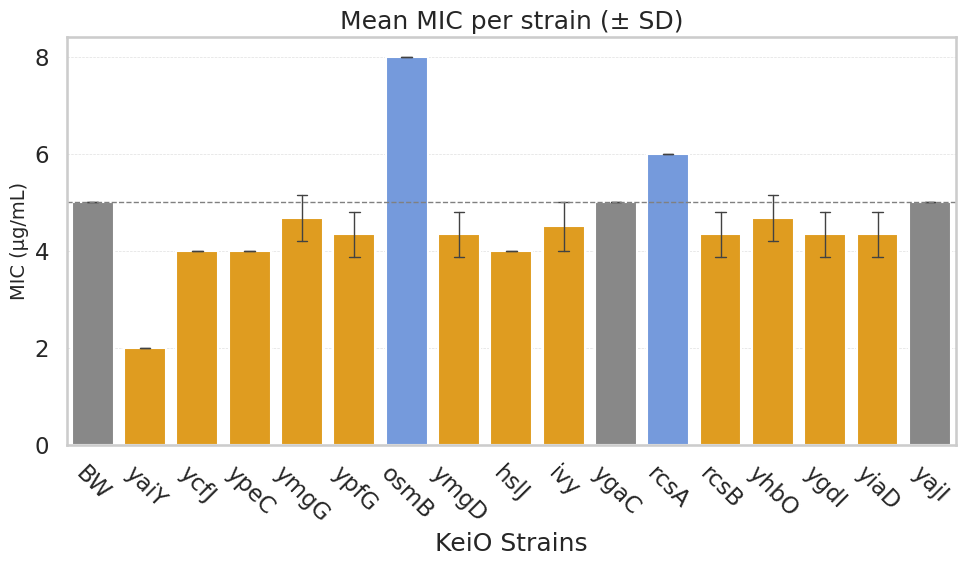

In [42]:
# Compute summary stats
summary = mic_df.groupby('Strain')['MIC_ugml'].agg(['mean', 'std']).reset_index()

# Get WT MIC (assumed to be first in order)
wt_mic = summary.loc[summary['Strain'] == strain_order[0], 'mean'].values[0]

# Assign colors
def assign_color(mic):
    if abs(mic - wt_mic) < 1e-6:
        return '#888888'  # neutral grey
    elif mic > wt_mic:
        return 'cornflowerblue'  # reddish (higher resistance)
    else:
        return 'orange'  # bluish (lower resistance)

colors = [assign_color(m) for m in summary.set_index('Strain').loc[strain_order, 'mean']]

# Plot
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=mic_df,
    x='Strain', y='MIC_ugml',
    ci='sd', capsize=0.2, errwidth=1.0,
    order=strain_order,
    palette=colors
)

ax.axhline(wt_mic, color='gray', linestyle='--', linewidth=1)

# Add grid under bars
ax.set_axisbelow(True)
ax.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.6)

# Axis labels
ax.set_ylabel('MIC (µg/mL)', fontsize=14)
ax.set_xlabel('KeiO Strains')
plt.xticks(rotation=-45)
plt.title('Mean MIC per strain (± SD)')
plt.tight_layout()
plt.show()

In [43]:
def plot_growth_curves_matplotlib(strain_name, df):
    import matplotlib.pyplot as plt

    # Filter for the strain
    df_strain = df[df['Strain'] == strain_name].copy()

    # Compute mean OD over replicates for each time and concentration
    mean_curve = (
        df_strain
        .groupby(['Time', 'Concentration'])['OD']
        .mean()
        .reset_index()
    )

    # Pivot for plotting: rows = time, columns = concentration
    pivot_df = mean_curve.pivot(index='Time', columns='Concentration', values='OD')

    # Plot
    plt.figure(figsize=(10, 6))
    for conc in pivot_df.columns:
        plt.plot(
            pivot_df.index,
            pivot_df[conc],
            marker='o',
            markersize=3,
            linestyle='-',
            linewidth=1.5,
            label=conc
        )

    plt.axvline(x=20, color='gray', linestyle='--', linewidth=1)
    plt.xlabel('Time (Hours)')
    plt.ylabel('OD600')
    plt.title(f'{strain_name} Growth Curve')
    plt.legend(title='Conc.(µg/mL)', bbox_to_anchor=(1.1, 1), loc='upper left')
    plt.grid(linestyle='--', linewidth=1, alpha=0.6)
    plt.tight_layout()
    plt.show()

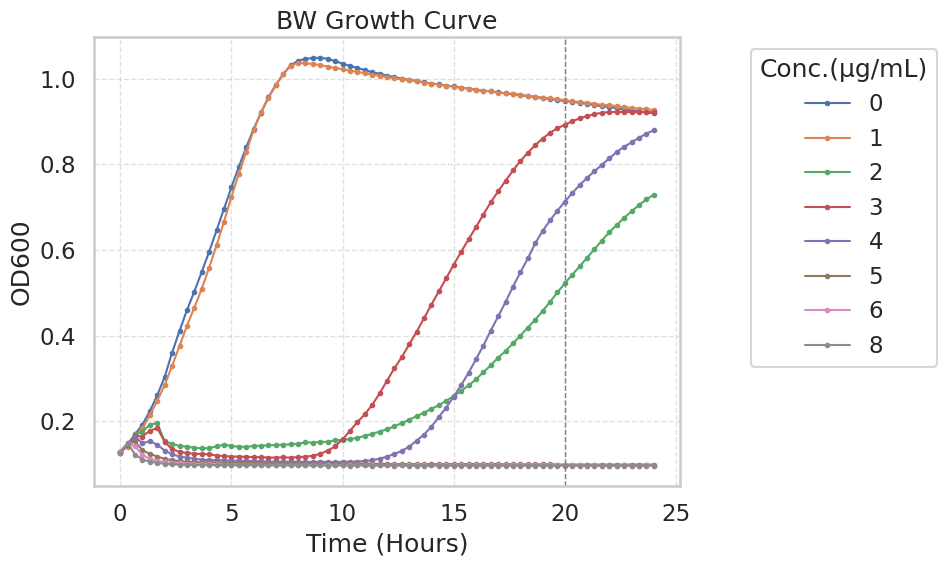

In [44]:
plot_growth_curves_matplotlib('BW',long_df1)

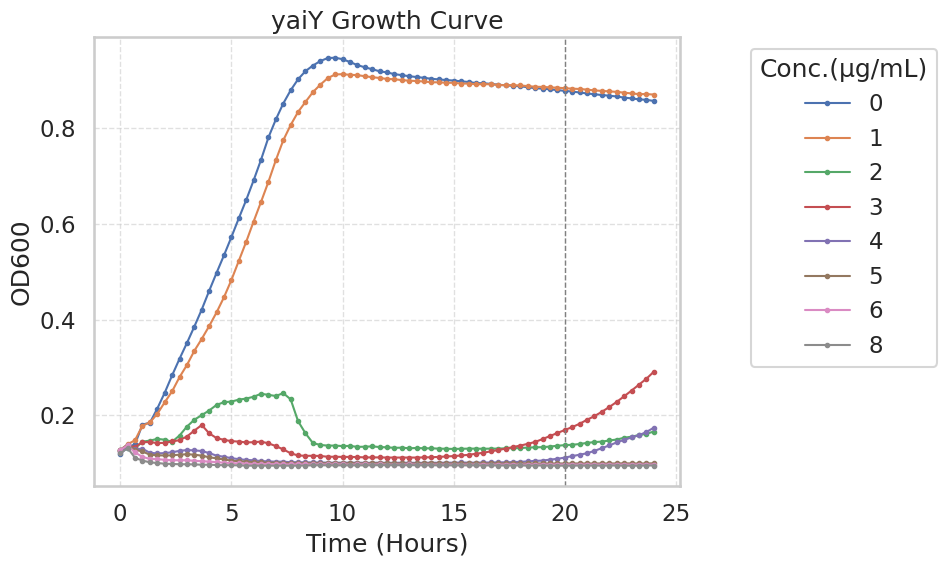

In [45]:
plot_growth_curves_matplotlib('yaiY',long_df1)

## SI Figure 4

In [46]:
matplotlib.style.use('default')

<AxesSubplot:ylabel='LexA iModulon\nActivity'>

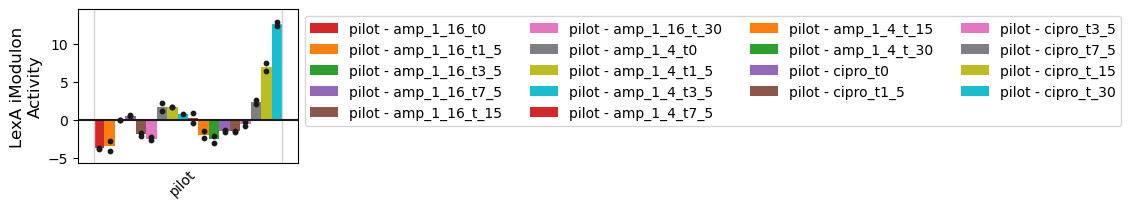

In [47]:
plot_activities(ica_data,'LexA',projects='pilot')

<AxesSubplot:xlabel='pilot:amp_1_16_t0', ylabel='pilot:amp_1_4_t0'>

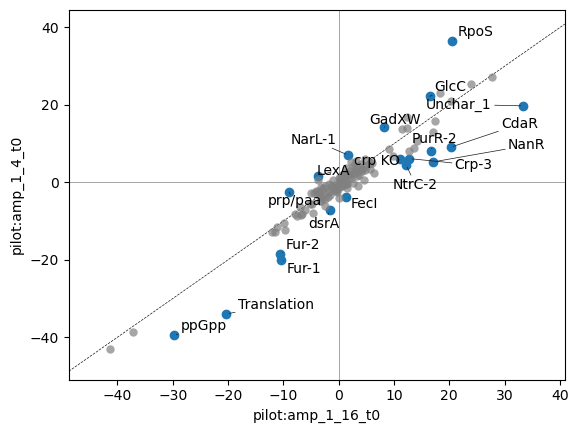

In [48]:
plot_dima(ica_data,'pilot:amp_1_16_t0','pilot:amp_1_4_t0')

<AxesSubplot:xlabel='pilot:amp_1_16_t1_5', ylabel='pilot:amp_1_4_t1_5'>

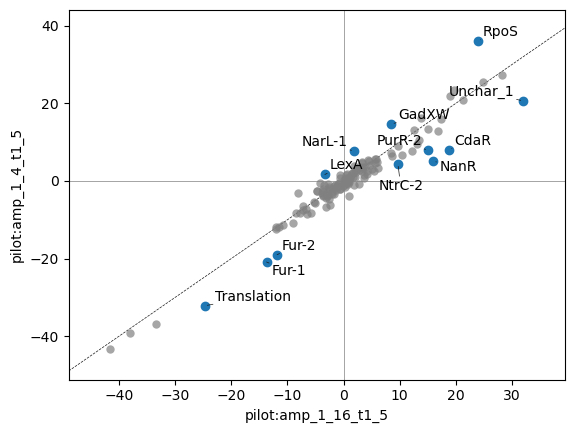

In [49]:
plot_dima(ica_data,'pilot:amp_1_16_t1_5','pilot:amp_1_4_t1_5')

<AxesSubplot:xlabel='pilot:amp_1_16_t3_5', ylabel='pilot:amp_1_4_t3_5'>

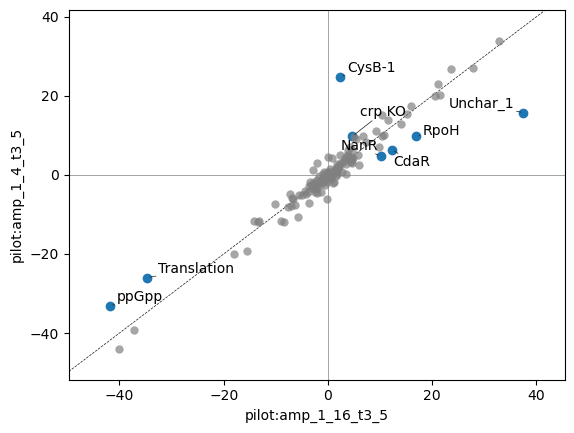

In [50]:
plot_dima(ica_data,'pilot:amp_1_16_t3_5','pilot:amp_1_4_t3_5')

<AxesSubplot:xlabel='pilot:amp_1_16_t7_5', ylabel='pilot:amp_1_4_t7_5'>

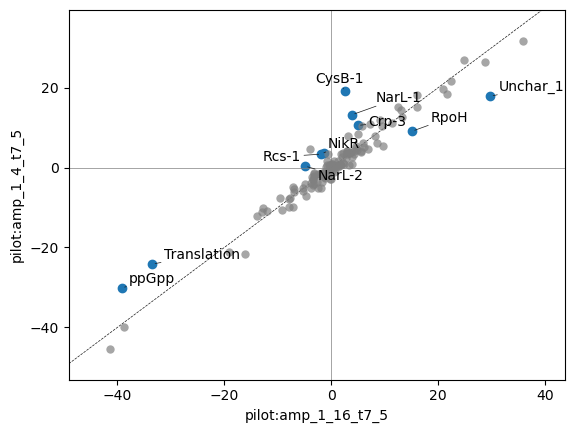

In [51]:
plot_dima(ica_data,'pilot:amp_1_16_t7_5','pilot:amp_1_4_t7_5')

<AxesSubplot:xlabel='pilot:amp_1_16_t_15', ylabel='pilot:amp_1_4_t_15'>

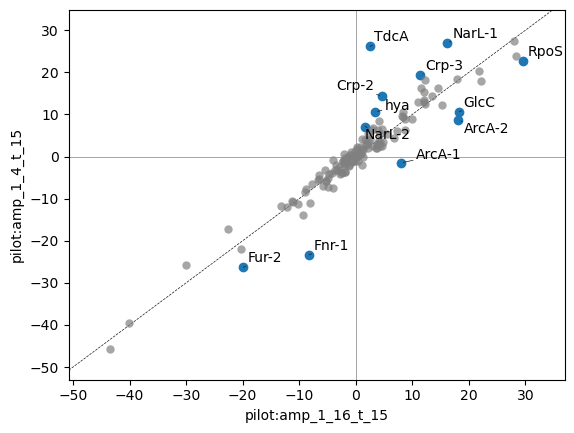

In [52]:
plot_dima(ica_data,'pilot:amp_1_16_t_15','pilot:amp_1_4_t_15')

<AxesSubplot:xlabel='pilot:amp_1_16_t_30', ylabel='pilot:amp_1_4_t_30'>

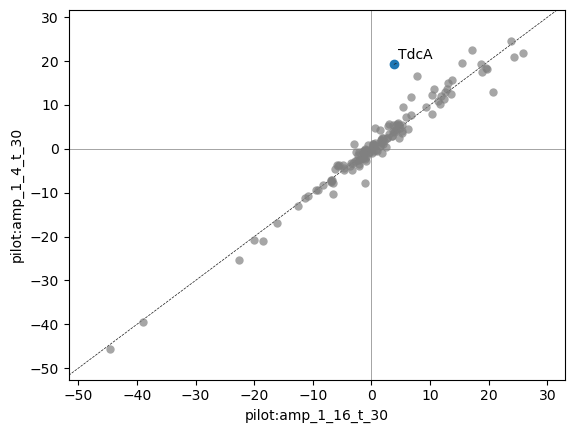

In [53]:
plot_dima(ica_data,'pilot:amp_1_16_t_30','pilot:amp_1_4_t_30')

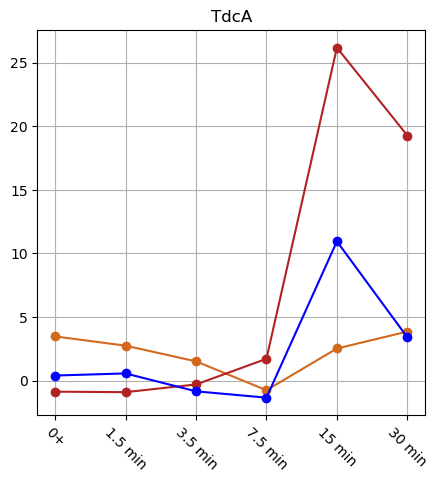

In [54]:
plt.figure(figsize=(5,5))
plt.plot(amp16_activity(ica_data,['TdcA']).T,'-o',color='chocolate')
plt.plot(amp4_activity(ica_data,['TdcA']).T,'-o',color='firebrick')
plt.plot(cipro_activity(ica_data,['TdcA']).T,'-o',color='blue')
plt.xticks(rotation=-45)
plt.title('TdcA')
plt.grid(True)

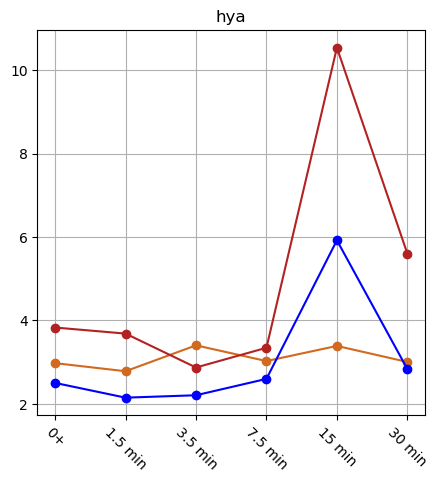

In [55]:
plt.figure(figsize=(5,5))
plt.plot(amp16_activity(ica_data,['hya']).T,'-o',color='chocolate')
plt.plot(amp4_activity(ica_data,['hya']).T,'-o',color='firebrick')
plt.plot(cipro_activity(ica_data,['hya']).T,'-o',color='blue')
plt.xticks(rotation=-45)
plt.title('hya')
plt.grid(True)

## SI Figure 5

posx and posy should be finite values
posx and posy should be finite values


<AxesSubplot:xlabel='Gene Start', ylabel='YmfT Gene Weight'>

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


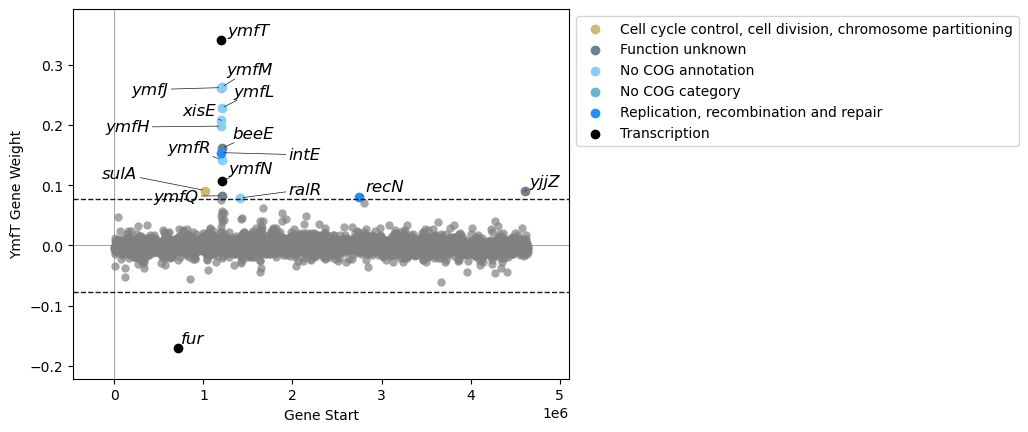

In [56]:
plot_gene_weights(ica_data,'YmfT',show_labels=True)

## SI Figure 6

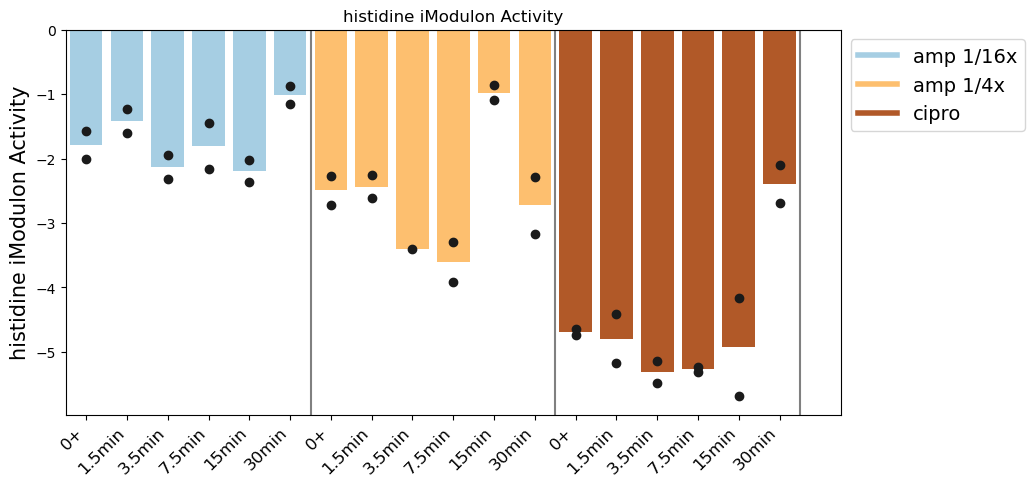

In [57]:
activity_barplot('histidine')